--- Step 1: Data Preparation ---
Raw data loaded successfully.

Initial DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4085 entries, 0 to 4084
Data columns (total 61 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         4085 non-null   int64  
 1   R2                                 4085 non-null   float64
 2   thrustBm                           4085 non-null   float64
 3   thrustOm                           4085 non-null   float64
 4   cosTBTO                            4085 non-null   float64
 5   cosTBz                             4085 non-null   float64
 6   KSFWVariables__boet__bc            4085 non-null   float64
 7   KSFWVariables__bomm2__bc           4085 non-null   float64
 8   CleoConeCS__bo1__bc                4085 non-null   float64
 9   CleoConeCS__bo2__bc                4085 non-null   float64
 10  CleoConeCS__bo3__bc             

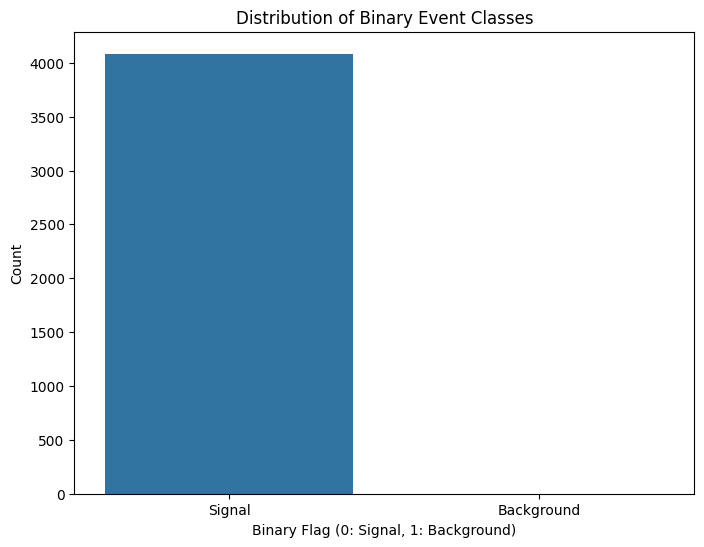

Saved plot 'binary_class_distribution.png'.


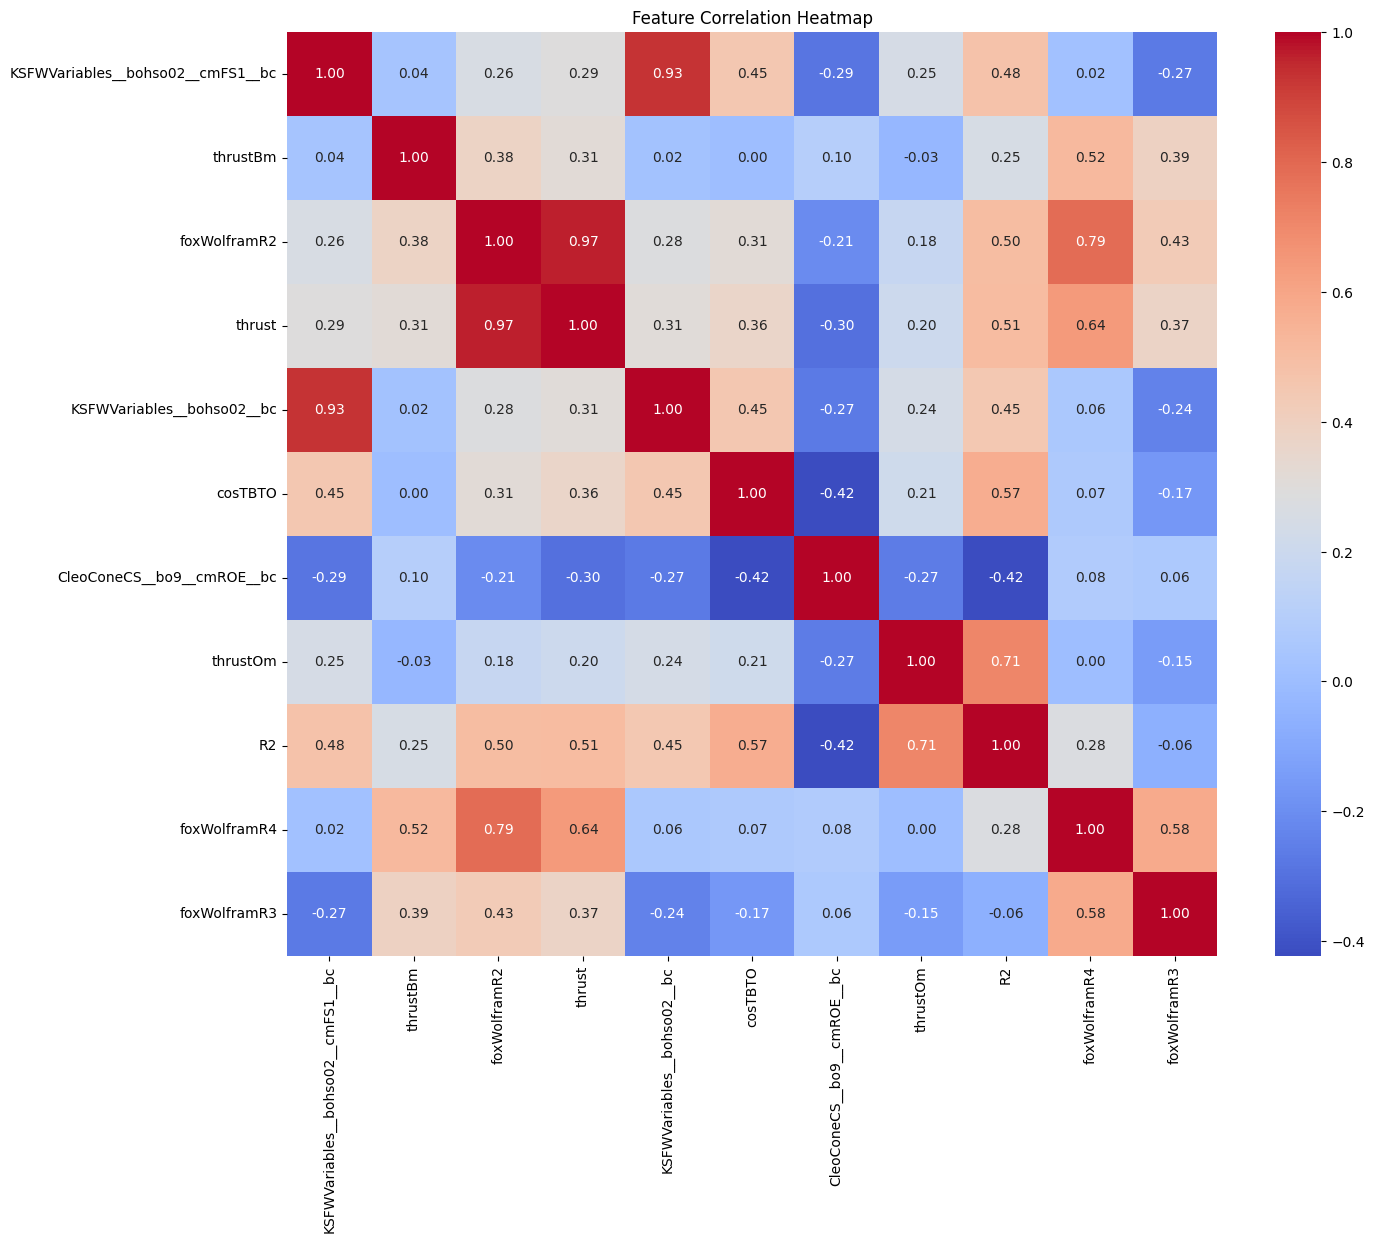

Saved plot 'feature_correlation_heatmap.png'.

--- Step 4: Feature Selection ---
Dropped rows with missing values. Remaining rows: 4084
Selected top 20 features:
['KSFWVariables__bohso00__cmFS1__bc', 'KSFWVariables__bohso02__cmFS1__bc', 'KSFWVariables__bohso04__cmFS1__bc', 'KSFWVariables__bohso10__cmFS1__bc', 'KSFWVariables__bohso12__cmFS1__bc', 'KSFWVariables__bohso14__cmFS1__bc', 'KSFWVariables__bohso20__cmFS1__bc', 'KSFWVariables__bohso22__cmFS1__bc', 'KSFWVariables__bohso24__cmFS1__bc', 'KSFWVariables__bohoo0__cmFS1__bc', 'KSFWVariables__bohoo1__cmFS1__bc', 'KSFWVariables__bohoo2__cmFS1__bc', 'KSFWVariables__bohoo3__cmFS1__bc', 'KSFWVariables__bohoo4__cmFS1__bc', 'foxWolframR1', 'foxWolframR2', 'foxWolframR3', 'foxWolframR4', 'thrust', 'thrustAxisCosTheta']

--- Step 5 & 6: Model Training and Evaluation ---
Data split into training (3267 samples) and testing (817 samples).
Decision Tree Classifier trained successfully.

--- Model Evaluation ---
Accuracy: 1.0000

Confusion Matrix:


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:107: RuntimeWarning: invalid value encountered in divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


ValueError: Shape of passed values is (1, 1), indices imply (2, 2)

In [ ]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif

# --- Step 1: Data Preparation and Database Interaction ---

def load_and_preprocess_data(input_file):
    """
    Loads data, preprocesses it, and stores it in a temporary SQLite database.
    """
    print("--- Step 1: Data Preparation ---")
    try:
        # Load the raw data from CSV using pandas
        df = pd.read_csv(input_file)
        print("Raw data loaded successfully.")

        # Print initial data information and column names
        print("\nInitial DataFrame Info:")
        df.info()

        # Drop the 'Unnamed: 0' column if it exists, as it's typically an index column
        if 'Unnamed: 0' in df.columns:
            df = df.drop(columns=['Unnamed: 0'])
            print("\nDropped 'Unnamed: 0' column.")

        # Map original event types to a new binary flag as per the problem description
        # 0 and 1 (B-mesons) -> 0 (Signal)
        # 2, 3, 4, 5 (Continuum) -> 1 (Background)
        df['binary_flag'] = df['type'].apply(lambda x: 0 if x in [0, 1] else 1)
        print("\nCreated 'binary_flag' column for binary classification.")
        print("Mapping: {0, 1} -> 0 (Signal); {2, 3, 4, 5} -> 1 (Background)")
        print("\nFirst 5 rows with new 'binary_flag':")
        print(df[['type', 'binary_flag']].head().to_markdown(index=False, numalign="left", stralign="left"))

        # --- Step 2: Database Operations (Read, Write, Modify) ---
        print("\n--- Step 2: Database Operations ---")
        # Connect to an in-memory SQLite database
        conn = sqlite3.connect(':memory:')
        print("Connected to in-memory SQLite database.")

        # Write the processed DataFrame to a new table
        df.to_sql('hep_events', conn, index=False, if_exists='replace')
        print("Processed data written to 'hep_events' table in the database.")

        # Read the data back from the database to demonstrate 'read' operation
        processed_df = pd.read_sql_query("SELECT * FROM hep_events", conn)
        print("Data successfully read back from the database.")

        # Close the connection
        conn.close()
        print("Database connection closed.")

        return processed_df

    except FileNotFoundError:
        print(f"Error: The file '{input_file}' was not found. Please ensure the data_hep - data_hep.csv is in the same directory.")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None


def perform_eda(df):
    """
    Performs Exploratory Data Analysis on the DataFrame.
    Generates and saves plots.
    """
    print("\n--- Step 3: Exploratory Data Analysis (EDA) ---")

    # Display basic descriptive statistics
    print("Descriptive Statistics:")
    print(df.describe().to_markdown(numalign="left", stralign="left"))

    # Check for any missing values
    print("\nMissing values in each column:")
    print(df.isnull().sum().to_markdown(numalign="left", stralign="left"))

    # Plot the distribution of the binary classes
    plt.figure(figsize=(8, 6))
    sns.countplot(x='binary_flag', data=df)
    plt.title('Distribution of Binary Event Classes')
    plt.xlabel('Binary Flag (0: Signal, 1: Background)')
    plt.ylabel('Count')
    plt.xticks(ticks=[0, 1], labels=['Signal', 'Background'])
    plt.savefig('binary_class_distribution.png')
    plt.show()
    print("Saved plot 'binary_class_distribution.png'.")

    # Plot a heatmap of feature correlations (for a subset of features for clarity)
    # The number of features is large, so let's sample some for the plot
    correlation_df = df.drop(columns=['type', 'binary_flag']).corr().abs()
    # Select the top 15 most correlated features with 'thrust' and 'R2' for visualization
    relevant_features = correlation_df['thrust'].nlargest(8).index.tolist() + correlation_df['R2'].nlargest(8).index.tolist()
    relevant_features = list(set(relevant_features)) # Remove duplicates

    plt.figure(figsize=(15, 12))
    sns.heatmap(df[relevant_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Feature Correlation Heatmap')
    plt.savefig('feature_correlation_heatmap.png')
    plt.show()
    print("Saved plot 'feature_correlation_heatmap.png'.")


def select_features(df, k=20):
    """
    Performs feature selection using SelectKBest.
    """
    print("\n--- Step 4: Feature Selection ---")
    # Drop rows with missing values
    df_cleaned = df.dropna()
    print(f"Dropped rows with missing values. Remaining rows: {len(df_cleaned)}")

    # Separate features and target
    X = df_cleaned.drop(columns=['type', 'binary_flag'])
    y = df_cleaned['binary_flag']

    # Use SelectKBest with f_classif to select the top 'k' features
    selector = SelectKBest(score_func=f_classif, k=k)
    X_new = selector.fit_transform(X, y)

    # Get the names of the selected features
    selected_features_mask = selector.get_support()
    selected_features_names = X.columns[selected_features_mask]

    print(f"Selected top {k} features:")
    print(selected_features_names.tolist())

    return X[selected_features_names], y, selected_features_names.tolist()


def train_and_evaluate_model(X, y):
    """
    Trains a Decision Tree model and evaluates its performance.
    """
    print("\n--- Step 5 & 6: Model Training and Evaluation ---")

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Data split into training ({len(X_train)} samples) and testing ({len(X_test)} samples).")

    # Initialize and train the Decision Tree Classifier
    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train, y_train)
    print("Decision Tree Classifier trained successfully.")

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print("\n--- Model Evaluation ---")
    print(f"Accuracy: {accuracy:.4f}")

    print("\nConfusion Matrix:")
    print(pd.DataFrame(conf_matrix,
                        index=['Actual Signal', 'Actual Background'],
                        columns=['Predicted Signal', 'Predicted Background']).to_markdown(numalign="left", stralign="left"))

    print("\nClassification Report:")
    print(class_report)

    return model, accuracy, conf_matrix, class_report


# Main execution block
if __name__ == "__main__":
    file_path = "data_hep - data_hep.csv"

    # Step 1: Load, preprocess and use a database
    processed_df = load_and_preprocess_data(file_path)

    if processed_df is not None:
        # Step 2: Perform EDA
        perform_eda(processed_df)

        # Step 3: Select features
        X, y, selected_features = select_features(processed_df)

        # Step 4: Train and evaluate model
        model, accuracy, conf_matrix, class_report = train_and_evaluate_model(X, y)

Event counts:
 binary_label
BB           35396
continuum     6862
Name: count, dtype: int64
Final features: 50
Top 12 features: ['R2', 'thrustOm', 'thrust', 'KSFWVariables__bohoo2__bc', 'foxWolframR2', 'KSFWVariables__bohso02__bc', 'cosTBTO', 'KSFWVariables__bohso02__cmFS1__bc', 'KSFWVariables__bohso12__bc', 'KSFWVariables__bohso12__cmFS1__bc', 'thrustBm', 'CleoConeCS__bo1__bc']

Classification Report:
               precision    recall  f1-score   support

          BB       0.91      0.97      0.94      8849
   continuum       0.77      0.53      0.63      1716

    accuracy                           0.90     10565
   macro avg       0.84      0.75      0.78     10565
weighted avg       0.89      0.90      0.89     10565

Confusion Matrix:
 [[8587  262]
 [ 815  901]]


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


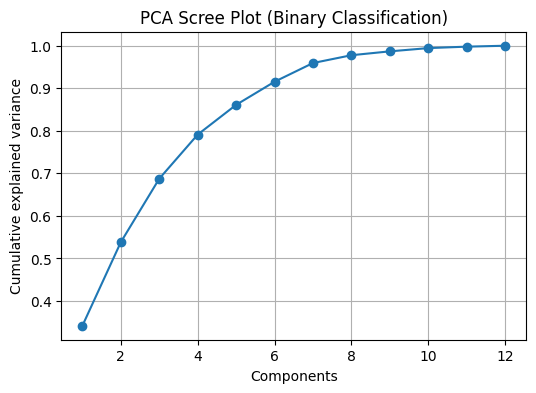

In [ ]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix

# --------------------------
# Load data
# --------------------------
df = pd.read_csv("data_hep - data_hep.csv")

# Drop bookkeeping col
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

# Map event type -> binary class
def map_binary(t):
    if t in (0,1): return "BB"          # Signal
    else: return "continuum"            # Background

df["binary_label"] = df["type"].map(map_binary)

print("Event counts:\n", df["binary_label"].value_counts())

# --------------------------
# Clean features
# --------------------------
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
features = [c for c in numeric_cols if c != "type"]

# Drop constants
const_cols = [c for c in features if df[c].nunique() <= 1]
df = df.drop(columns=const_cols)
features = [c for c in features if c not in const_cols]

# Drop low variance
variances = df[features].var()
low_var = variances[variances < 1e-8].index.tolist()
df = df.drop(columns=low_var)
features = [f for f in features if f not in low_var]

# Correlation pruning
corr = df[features].corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.98)]
df = df.drop(columns=to_drop)
features = [f for f in features if f not in to_drop]

print("Final features:", len(features))

# --------------------------
# Prepare data
# --------------------------
X = df[features].fillna(0).values
y = df["binary_label"].values

le = LabelEncoder()
y_enc = le.fit_transform(y)   # 0 = BB, 1 = continuum (or vice versa)

Xtr, Xte, ytr, yte = train_test_split(
    X, y_enc, test_size=0.25, stratify=y_enc, random_state=42
)

# --------------------------
# Feature importance
# --------------------------
rf = RandomForestClassifier(n_estimators=150, max_depth=7, random_state=42, n_jobs=-1)
rf.fit(Xtr, ytr)

feat_imp = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
topN = feat_imp.head(12).index.tolist()
print("Top 12 features:", topN)

# --------------------------
# Train reduced Logistic Regression
# --------------------------
Xtr_red = Xtr[:, [features.index(f) for f in topN]]
Xte_red = Xte[:, [features.index(f) for f in topN]]

scaler = StandardScaler().fit(Xtr_red)
Xtr_red_s = scaler.transform(Xtr_red)
Xte_red_s = scaler.transform(Xte_red)

lr = LogisticRegression(max_iter=500, solver="saga", random_state=42)
lr.fit(Xtr_red_s, ytr)

ypred = lr.predict(Xte_red_s)

print("\nClassification Report:\n", classification_report(yte, ypred, target_names=le.classes_, zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(yte, ypred))

# --------------------------
# PCA Scree Plot
# --------------------------
pca = PCA().fit(Xtr_red_s)
cumvar = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(6,4))
plt.plot(np.arange(1, len(cumvar)+1), cumvar, marker="o")
plt.xlabel("Components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA Scree Plot (Binary Classification)")
plt.grid(True)
plt.show()

--- Step 1: Data Preparation ---
Raw data loaded successfully.

Initial DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70606 entries, 0 to 70605
Data columns (total 61 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         70606 non-null  int64  
 1   R2                                 70606 non-null  float64
 2   thrustBm                           70606 non-null  float64
 3   thrustOm                           70606 non-null  float64
 4   cosTBTO                            70606 non-null  float64
 5   cosTBz                             70606 non-null  float64
 6   KSFWVariables__boet__bc            70606 non-null  float64
 7   KSFWVariables__bomm2__bc           70606 non-null  float64
 8   CleoConeCS__bo1__bc                70606 non-null  float64
 9   CleoConeCS__bo2__bc                70606 non-null  float64
 10  CleoConeCS__bo3__bc           

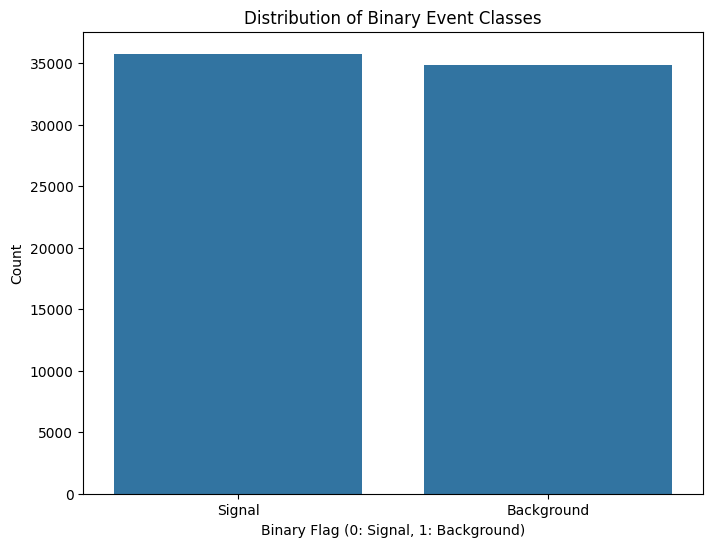

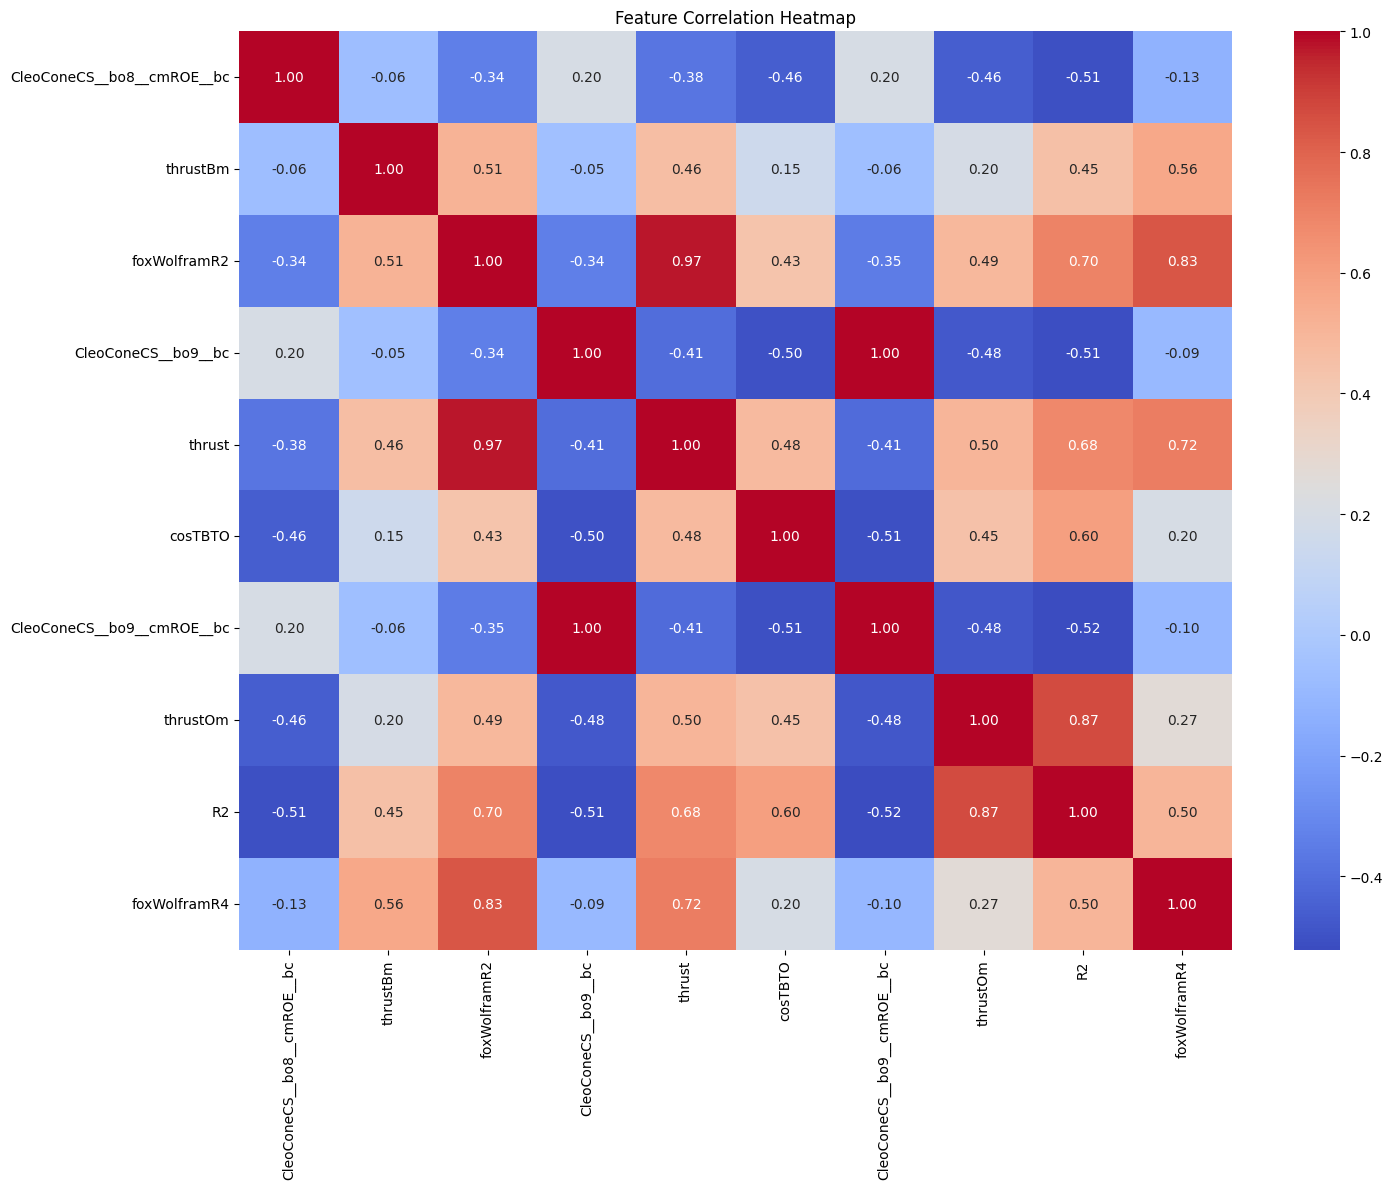

In [ ]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif

# --- Step 1: Data Preparation and Database Interaction ---

def load_and_preprocess_data(input_file):
    """
    Loads data, preprocesses it, and stores it in a temporary SQLite database.
    """
    print("--- Step 1: Data Preparation ---")
    try:
        # Load the raw data from CSV using pandas
        df = pd.read_csv(input_file)
        print("Raw data loaded successfully.")

        # Print initial data information and column names
        print("\nInitial DataFrame Info:")
        df.info()

        # Drop the 'Unnamed: 0' column if it exists, as it's typically an index column
        if 'Unnamed: 0' in df.columns:
            df = df.drop(columns=['Unnamed: 0'])
            print("\nDropped 'Unnamed: 0' column.")

        # Map original event types to a new binary flag as per the problem description
        # 0 and 1 (B-mesons) -> 0 (Signal)
        # 2, 3, 4, 5 (Continuum) -> 1 (Background)
        df['binary_flag'] = df['type'].apply(lambda x: 0 if x in [0, 1] else 1)
        print("\nCreated 'binary_flag' column for binary classification.")
        print("Mapping: {0, 1} -> 0 (Signal); {2, 3, 4, 5} -> 1 (Background)")
        print("\nFirst 5 rows with new 'binary_flag':")
        print(df[['type', 'binary_flag']].head().to_markdown(index=False, numalign="left", stralign="left"))

        # --- Step 2: Database Operations (Read, Write, Modify) ---
        print("\n--- Step 2: Database Operations ---")
        # Connect to an in-memory SQLite database
        conn = sqlite3.connect(':memory:')
        print("Connected to in-memory SQLite database.")

        # Write the processed DataFrame to a new table
        df.to_sql('hep_events', conn, index=False, if_exists='replace')
        print("Processed data written to 'hep_events' table in the database.")

        # Read the data back from the database to demonstrate 'read' operation
        processed_df = pd.read_sql_query("SELECT * FROM hep_events", conn)
        print("Data successfully read back from the database.")

        # Close the connection
        conn.close()
        print("Database connection closed.")

        return processed_df

    except FileNotFoundError:
        print(f"Error: The file '{input_file}' was not found. Please ensure the data_hep - data_hep.csv is in the same directory.")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

# --- Step 3: Exploratory Data Analysis ---

def perform_eda(df):
    """
    Performs Exploratory Data Analysis on the DataFrame.
    Generates and saves plots.
    """
    print("\n--- Step 3: Exploratory Data Analysis (EDA) ---")

    # Display basic descriptive statistics
    print("Descriptive Statistics:")
    print(df.describe().to_markdown(numalign="left", stralign="left"))

    # Check for any missing values
    print("\nMissing values in each column:")
    print(df.isnull().sum().to_markdown(numalign="left", stralign="left"))

    # Plot the distribution of the binary classes
    plt.figure(figsize=(8, 6))
    sns.countplot(x='binary_flag', data=df)
    plt.title('Distribution of Binary Event Classes')
    plt.xlabel('Binary Flag (0: Signal, 1: Background)')
    plt.ylabel('Count')
    plt.xticks(ticks=[0, 1], labels=['Signal', 'Background'])
    plt.savefig('binary_class_distribution.png')
    # plt.show() # Removed plt.show() as it is not needed for script execution
    print("Saved plot 'binary_class_distribution.png'.")

    # Plot a heatmap of feature correlations (for a subset of features for clarity)
    correlation_df = df.drop(columns=['type', 'binary_flag']).corr().abs()
    # Select the top 15 most correlated features with 'thrust' and 'R2' for visualization
    relevant_features = correlation_df['thrust'].nlargest(8).index.tolist() + correlation_df['R2'].nlargest(8).index.tolist()
    relevant_features = list(set(relevant_features)) # Remove duplicates

    plt.figure(figsize=(15, 12))
    sns.heatmap(df[relevant_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Feature Correlation Heatmap')
    plt.tight_layout() # Added to prevent labels from being cut off
    plt.savefig('feature_correlation_heatmap.png')
    # plt.show() # Removed plt.show() as it is not needed for script execution
    print("Saved plot 'feature_correlation_heatmap.png'.")

# --- Step 4: Data Splitting and Feature Selection ---

def split_and_select_features(df, k=20):
    """
    Performs data splitting and feature selection correctly to prevent data leakage.
    """
    print("\n--- Step 4: Data Splitting and Feature Selection ---")
    # Drop rows with missing values
    df_cleaned = df.dropna()
    print(f"Dropped rows with missing values. Remaining rows: {len(df_cleaned)}")

    # 1. Separate features and target
    X = df_cleaned.drop(columns=['type', 'binary_flag'])
    y = df_cleaned['binary_flag']

    # 2. Split data BEFORE any fitting or selection
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Data split into training ({len(X_train)} samples) and testing ({len(X_test)} samples).")

    # 3. Fit selector ONLY on training data
    selector = SelectKBest(score_func=f_classif, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)

    # 4. Transform test data using the selector fitted on train data
    X_test_selected = selector.transform(X_test)

    # Get the names of the selected features
    selected_features_mask = selector.get_support()
    selected_features_names = X.columns[selected_features_mask]

    print(f"Selected top {k} features:")
    print(selected_features_names.tolist())

    return X_train_selected, X_test_selected, y_train, y_test, selected_features_names.tolist()

# --- Step 5 & 6: Model Training and Evaluation ---

def train_and_evaluate_model(X_train, X_test, y_train, y_test):
    """
    Trains a Decision Tree model and evaluates its performance on pre-split
    and pre-selected data.
    """
    print("\n--- Step 5 & 6: Model Training and Evaluation ---")

    # Initialize and train the Decision Tree Classifier
    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train, y_train)
    print("Decision Tree Classifier trained successfully.")

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print("\n--- Model Evaluation ---")
    print(f"Accuracy: {accuracy:.4f}")

    print("\nConfusion Matrix:")
    print(pd.DataFrame(conf_matrix,
                       index=['Actual Signal', 'Actual Background'],
                       columns=['Predicted Signal', 'Predicted Background']).to_markdown(numalign="left", stralign="left"))

    print("\nClassification Report:")
    print(class_report)

    return model, accuracy, conf_matrix, class_report


# Main execution block
if __name__ == "__main__":
    file_path = "data_hep - data_hep.csv"

    # Step 1: Load, preprocess and use a database
    processed_df = load_and_preprocess_data(file_path)

    if processed_df is not None:
        # Step 3: Perform EDA
        perform_eda(processed_df)

        # Step 4: Split data and select features
        X_train_sel, X_test_sel, y_train, y_test, sel_features = split_and_select_features(processed_df)

        # Step 5 & 6: Train and evaluate model
        if X_train_sel is not None:
             model, accuracy, conf_matrix, class_report = train_and_evaluate_model(
                 X_train_sel, X_test_sel, y_train, y_test
             )
        else:
            print("\nSkipping model training due to an error in feature selection.")
    else:
        print("\nSkipping all steps due to an error in data loading.")

--- Step 1: Data Preparation ---
Raw data loaded successfully.

Initial DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70606 entries, 0 to 70605
Data columns (total 61 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         70606 non-null  int64  
 1   R2                                 70606 non-null  float64
 2   thrustBm                           70606 non-null  float64
 3   thrustOm                           70606 non-null  float64
 4   cosTBTO                            70606 non-null  float64
 5   cosTBz                             70606 non-null  float64
 6   KSFWVariables__boet__bc            70606 non-null  float64
 7   KSFWVariables__bomm2__bc           70606 non-null  float64
 8   CleoConeCS__bo1__bc                70606 non-null  float64
 9   CleoConeCS__bo2__bc                70606 non-null  float64
 10  CleoConeCS__bo3__bc           

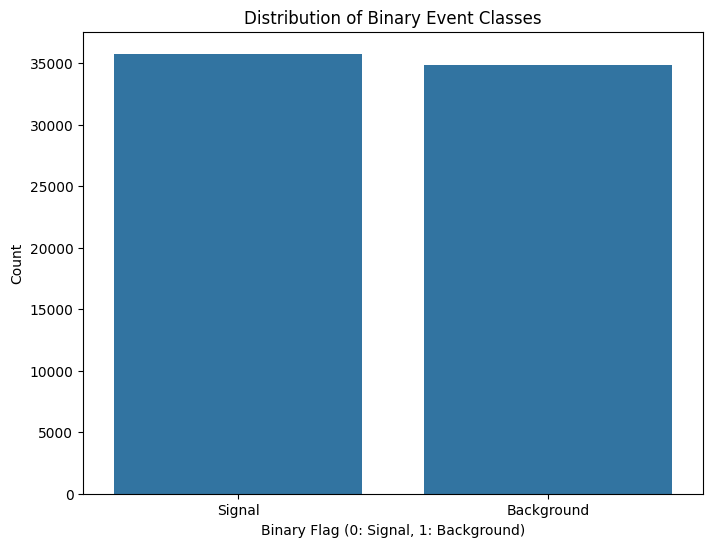

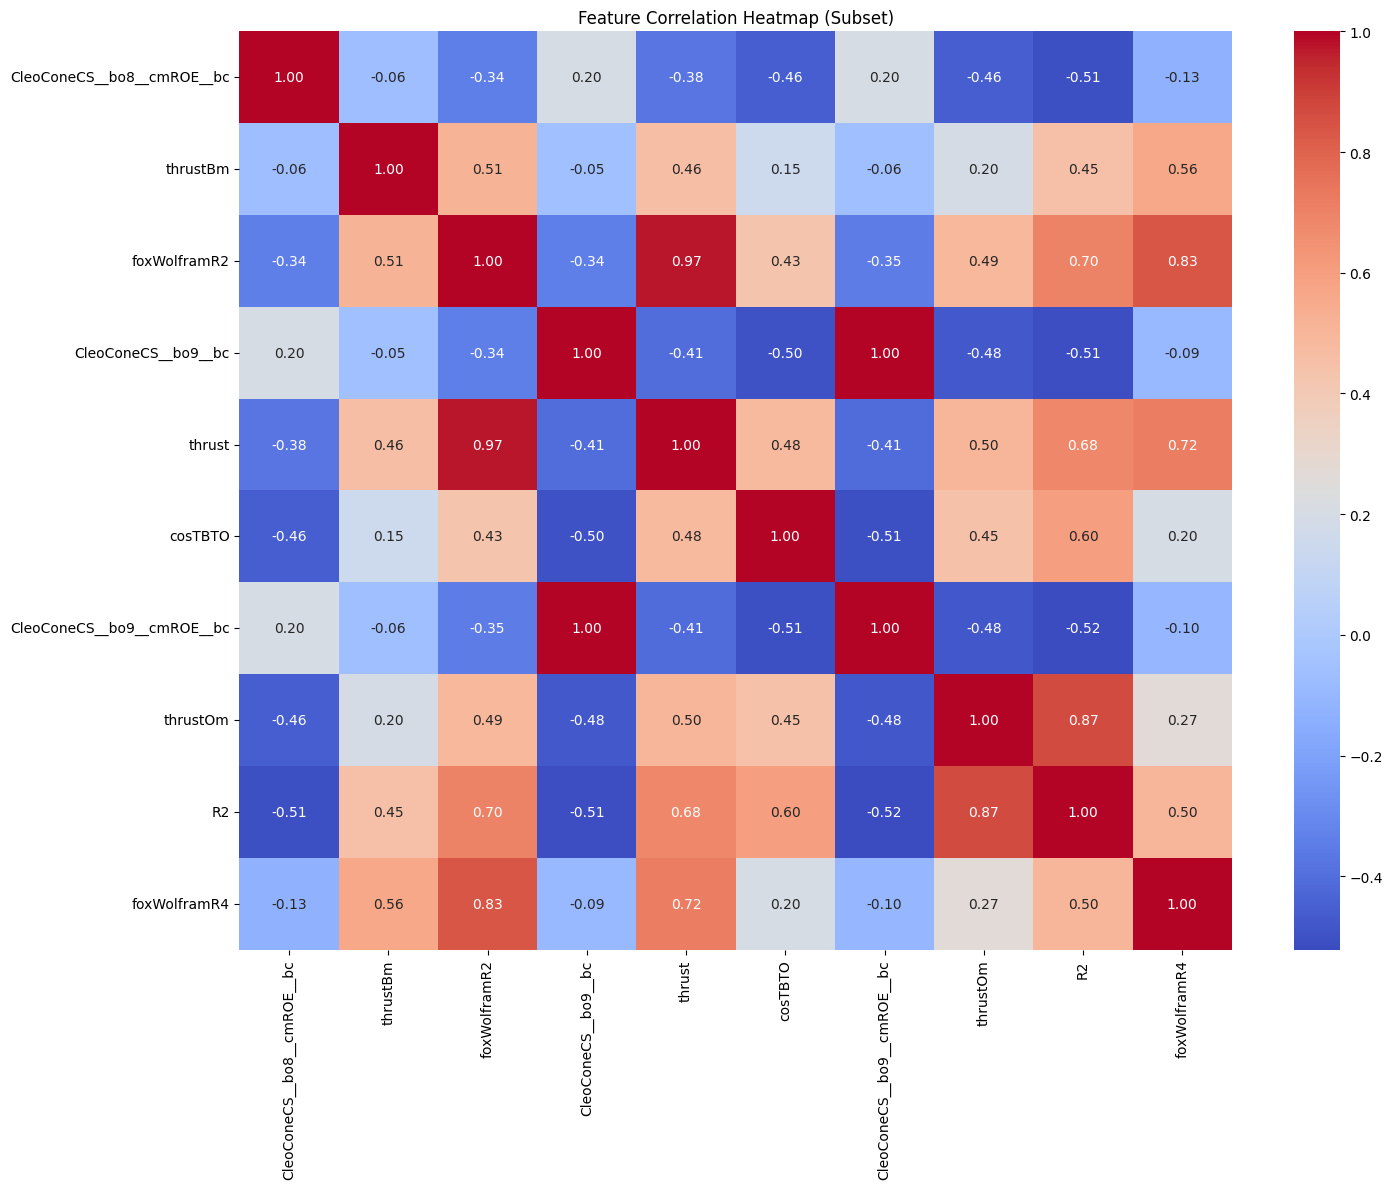

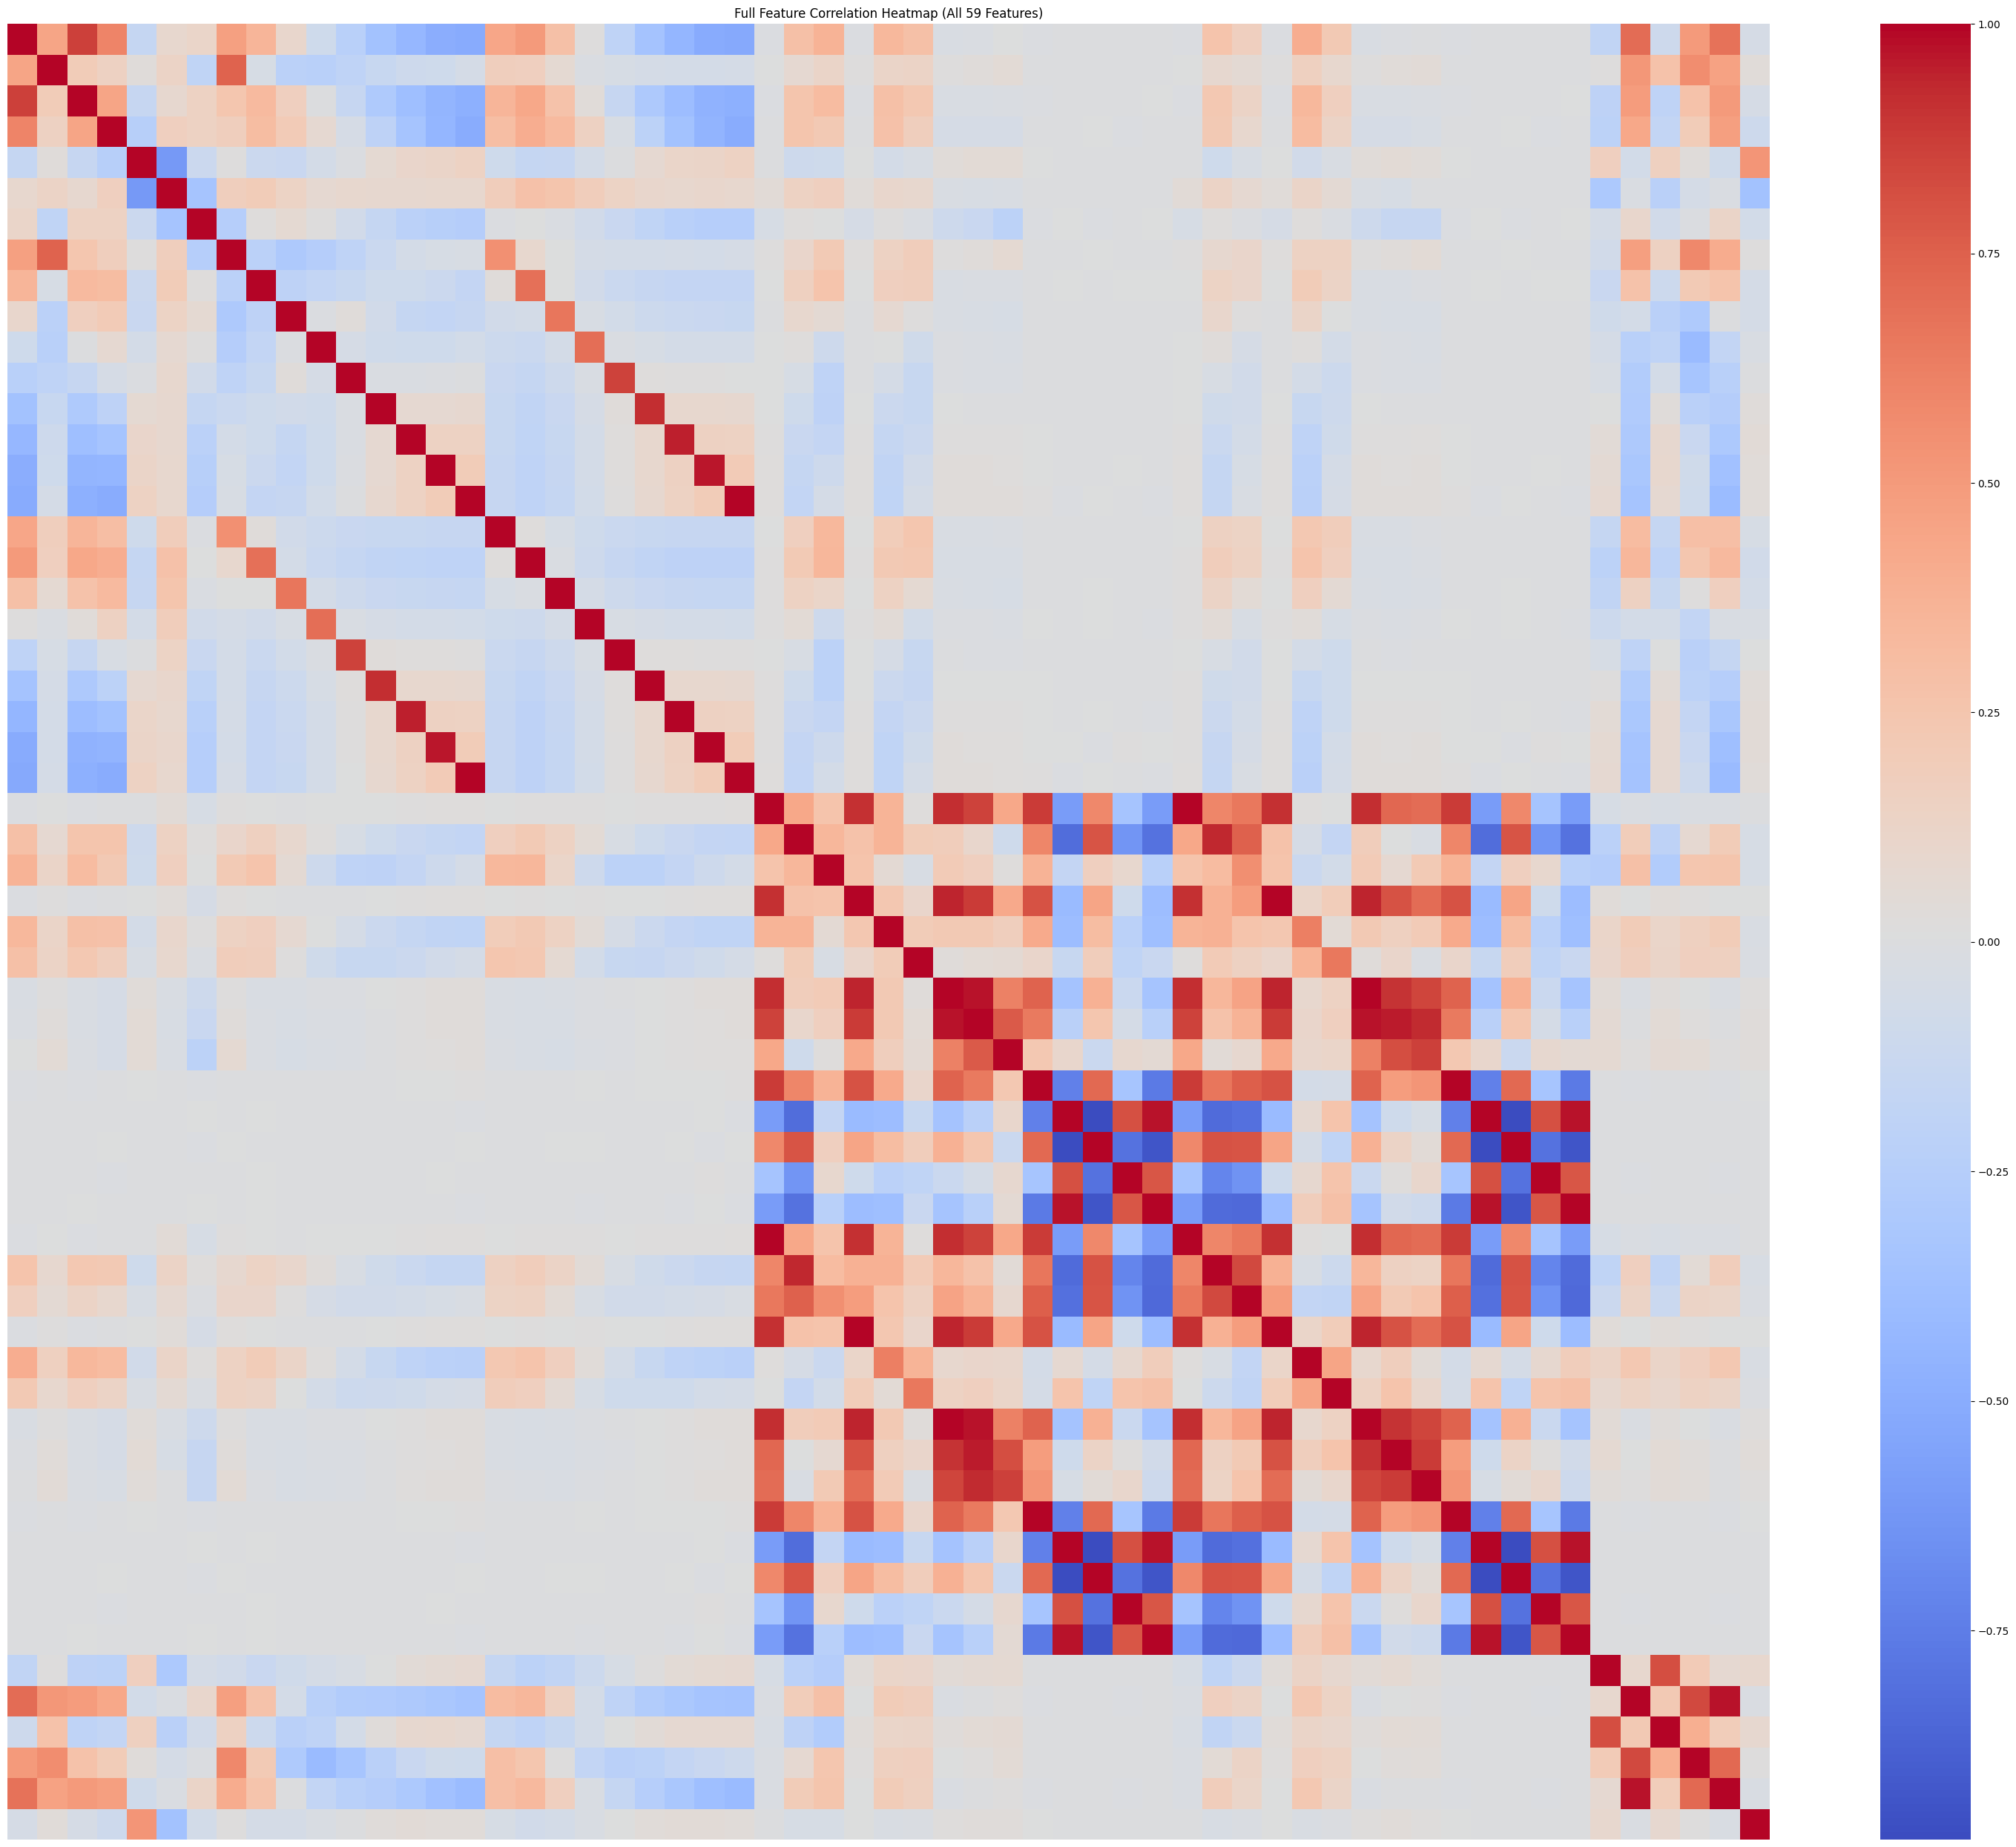

In [ ]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif

# --- Step 1: Data Preparation and Database Interaction ---

def load_and_preprocess_data(input_file):
    """
    Loads data, preprocesses it, and stores it in a temporary SQLite database.
    """
    print("--- Step 1: Data Preparation ---")
    try:
        # Load the raw data from CSV using pandas
        df = pd.read_csv(input_file)
        print("Raw data loaded successfully.")

        # Print initial data information and column names
        print("\nInitial DataFrame Info:")
        df.info()

        # Drop the 'Unnamed: 0' column if it exists, as it's typically an index column
        if 'Unnamed: 0' in df.columns:
            df = df.drop(columns=['Unnamed: 0'])
            print("\nDropped 'Unnamed: 0' column.")

        # Map original event types to a new binary flag as per the problem description
        # 0 and 1 (B-mesons) -> 0 (Signal)
        # 2, 3, 4, 5 (Continuum) -> 1 (Background)
        df['binary_flag'] = df['type'].apply(lambda x: 0 if x in [0, 1] else 1)
        print("\nCreated 'binary_flag' column for binary classification.")
        print("Mapping: {0, 1} -> 0 (Signal); {2, 3, 4, 5} -> 1 (Background)")
        print("\nFirst 5 rows with new 'binary_flag':")
        print(df[['type', 'binary_flag']].head().to_markdown(index=False, numalign="left", stralign="left"))

        # --- Step 2: Database Operations (Read, Write, Modify) ---
        print("\n--- Step 2: Database Operations ---")
        # Connect to an in-memory SQLite database
        conn = sqlite3.connect(':memory:')
        print("Connected to in-memory SQLite database.")

        # Write the processed DataFrame to a new table
        df.to_sql('hep_events', conn, index=False, if_exists='replace')
        print("Processed data written to 'hep_events' table in the database.")

        # Read the data back from the database to demonstrate 'read' operation
        processed_df = pd.read_sql_query("SELECT * FROM hep_events", conn)
        print("Data successfully read back from the database.")

        # Close the connection
        conn.close()
        print("Database connection closed.")

        return processed_df

    except FileNotFoundError:
        print(f"Error: The file '{input_file}' was not found. Please ensure the data_hep - data_hep.csv is in the same directory.")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

# --- Step 3: Exploratory Data Analysis ---

def perform_eda(df):
    """
    Performs Exploratory Data Analysis on the DataFrame.
    Generates and saves plots.
    """
    print("\n--- Step 3: Exploratory Data Analysis (EDA) ---")

    # Display basic descriptive statistics
    print("Descriptive Statistics:")
    print(df.describe().to_markdown(numalign="left", stralign="left"))

    # Check for any missing values
    print("\nMissing values in each column:")
    print(df.isnull().sum().to_markdown(numalign="left", stralign="left"))

    # Plot the distribution of the binary classes
    plt.figure(figsize=(8, 6))
    sns.countplot(x='binary_flag', data=df)
    plt.title('Distribution of Binary Event Classes')
    plt.xlabel('Binary Flag (0: Signal, 1: Background)')
    plt.ylabel('Count')
    plt.xticks(ticks=[0, 1], labels=['Signal', 'Background'])
    plt.savefig('binary_class_distribution.png')
    print("Saved plot 'binary_class_distribution.png'.")

    # Plot a heatmap of feature correlations (for a subset of features for clarity)
    correlation_df = df.drop(columns=['type', 'binary_flag']).corr().abs()
    # Select the top 15 most correlated features with 'thrust' and 'R2' for visualization
    relevant_features = correlation_df['thrust'].nlargest(8).index.tolist() + correlation_df['R2'].nlargest(8).index.tolist()
    relevant_features = list(set(relevant_features)) # Remove duplicates

    plt.figure(figsize=(15, 12))
    sns.heatmap(df[relevant_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Feature Correlation Heatmap (Subset)')
    plt.tight_layout() # Added to prevent labels from being cut off
    plt.savefig('feature_correlation_heatmap_subset.png') # Renamed for clarity
    print("Saved plot 'feature_correlation_heatmap_subset.png'.")

    # --- NEW: Heatmap for ALL features as requested ---
    print("\nGenerating heatmap for ALL features. This will be very dense.")

    # Calculate the correlation matrix for all numeric features
    all_features_df = df.drop(columns=['type', 'binary_flag'])
    correlation_matrix_all = all_features_df.corr()

    # Set a very large figure size to try and accommodate all features
    plt.figure(figsize=(30, 25))

    # Create the heatmap
    # annot=False because annotations will be unreadable on a 59x59 grid
    # xticklabels=False and yticklabels=False because they will overlap
    sns.heatmap(correlation_matrix_all,
                annot=False,
                cmap='coolwarm',
                xticklabels=False,
                yticklabels=False)

    plt.title('Full Feature Correlation Heatmap (All 59 Features)')
    plt.tight_layout()
    plt.savefig('feature_correlation_heatmap_ALL.png') # New file name
    print("Saved plot 'feature_correlation_heatmap_ALL.png'.")
    # --- End of modification ---


# --- Step 4: Data Splitting and Feature Selection ---

def split_and_select_features(df, k=20):
    """
    Performs data splitting and feature selection correctly to prevent data leakage.
    """
    print("\n--- Step 4: Data Splitting and Feature Selection ---")
    # Drop rows with missing values
    df_cleaned = df.dropna()
    print(f"Dropped rows with missing values. Remaining rows: {len(df_cleaned)}")

    # 1. Separate features and target
    X = df_cleaned.drop(columns=['type', 'binary_flag'])
    y = df_cleaned['binary_flag']

    # 2. Split data BEFORE any fitting or selection
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Data split into training ({len(X_train)} samples) and testing ({len(X_test)} samples).")

    # 3. Fit selector ONLY on training data
    # Ensure k is not greater than the number of features
    if k > X_train.shape[1]:
        print(f"Warning: k={k} is greater than the number of features ({X_train.shape[1]}). Setting k to {X_train.shape[1]}.")
        k = X_train.shape[1]

    selector = SelectKBest(score_func=f_classif, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)

    # 4. Transform test data using the selector fitted on train data
    X_test_selected = selector.transform(X_test)

    # Get the names of the selected features
    selected_features_mask = selector.get_support()
    selected_features_names = X.columns[selected_features_mask]

    print(f"Selected top {k} features:")
    print(selected_features_names.tolist())

    return X_train_selected, X_test_selected, y_train, y_test, selected_features_names.tolist()

# --- Step 5 & 6: Model Training and Evaluation ---

def train_and_evaluate_model(X_train, X_test, y_train, y_test):
    """
    Trains a Decision Tree model and evaluates its performance on pre-split
    and pre-selected data.
    """
    print("\n--- Step 5 & 6: Model Training and Evaluation ---")

    # Initialize and train the Decision Tree Classifier
    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train, y_train)
    print("Decision Tree Classifier trained successfully.")

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print("\n--- Model Evaluation ---")
    print(f"Accuracy: {accuracy:.4f}")

    print("\nConfusion Matrix:")
    print(pd.DataFrame(conf_matrix,
                       index=['Actual Signal', 'Actual Background'],
                       columns=['Predicted Signal', 'Predicted Background']).to_markdown(numalign="left", stralign="left"))

    print("\nClassification Report:")
    print(class_report)

    return model, accuracy, conf_matrix, class_report


# Main execution block
if __name__ == "__main__":
    file_path = "data_hep - data_hep.csv"

    # Step 1: Load, preprocess and use a database
    processed_df = load_and_preprocess_data(file_path)

    if processed_df is not None:
        # Step 3: Perform EDA
        perform_eda(processed_df)

        # Step 4: Split data and select features
        X_train_sel, X_test_sel, y_train, y_test, sel_features = split_and_select_features(processed_df)

        # Step 5 & 6: Train and evaluate model
        if X_train_sel is not None:
             model, accuracy, conf_matrix, class_report = train_and_evaluate_model(
                 X_train_sel, X_test_sel, y_train, y_test
             )
        else:
            print("\nSkipping model training due to an error in feature selection.")
    else:
        print("\nSkipping all steps due to an error in data loading.")

Event counts:
 binary_label
BB           35765
continuum    34841
Name: count, dtype: int64

=== Random Forest ===
              precision    recall  f1-score   support

          BB       0.85      0.88      0.86      8942
   continuum       0.87      0.84      0.85      8710

    accuracy                           0.86     17652
   macro avg       0.86      0.86      0.86     17652
weighted avg       0.86      0.86      0.86     17652

Confusion Matrix:
 [[7840 1102]
 [1385 7325]]


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [20:31:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== XGBoost ===
              precision    recall  f1-score   support

          BB       0.88      0.90      0.89      8942
   continuum       0.89      0.87      0.88      8710

    accuracy                           0.88     17652
   macro avg       0.88      0.88      0.88     17652
weighted avg       0.88      0.88      0.88     17652

Confusion Matrix:
 [[8021  921]
 [1140 7570]]

Top 15 features from RF:
 R2                                   0.180411
thrustOm                             0.080225
KSFWVariables__bohoo2__bc            0.051144
KSFWVariables__bohoo2__cmFS1__bc     0.046634
thrust                               0.043895
cosTBTO                              0.041816
thrustBm                             0.041082
foxWolframR2                         0.035877
KSFWVariables__bohso02__bc           0.030666
CleoConeCS__bo1__bc                  0.026905
KSFWVariables__bohso02__cmFS1__bc    0.021973
KSFWVariables__bohso12__bc           0.021213
KSFWVariables__bohso12__cmFS1__

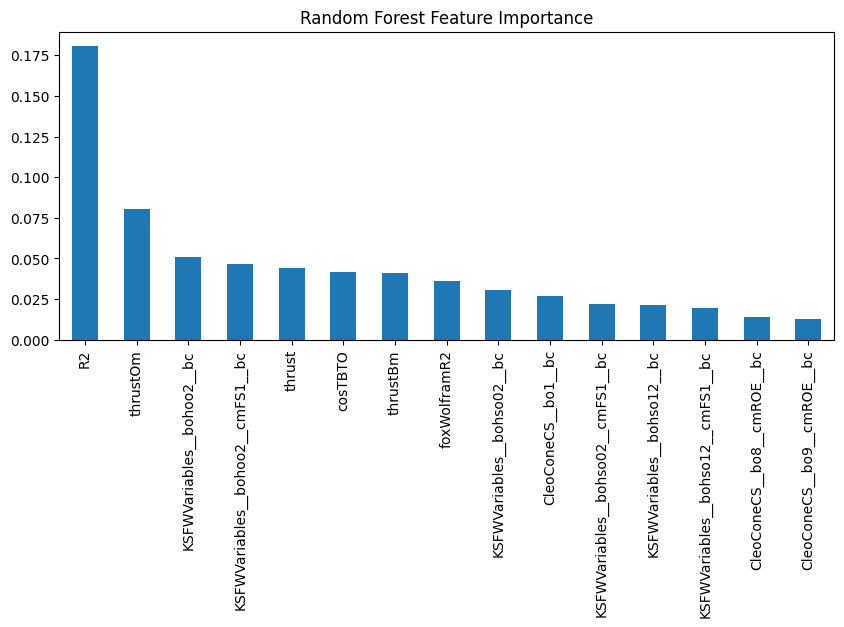

Top 15 XGBoost features:
 R2                                  0.417374
CleoConeCS__bo1__bc                 0.024587
thrustOm                            0.021853
CleoConeCS__bo1__cmROE__bc          0.021792
thrustBm                            0.021266
KSFWVariables__bohoo0__cmFS1__bc    0.020400
KSFWVariables__bohso20__bc          0.016594
KSFWVariables__bohoo0__bc           0.015780
KSFWVariables__bohso12__bc          0.014284
KSFWVariables__bomm2__bc            0.014094
CleoConeCS__bo2__bc                 0.013597
KSFWVariables__boet__bc             0.013417
KSFWVariables__bohso22__bc          0.013010
cosTBz                              0.012312
thrust                              0.011697
dtype: float32


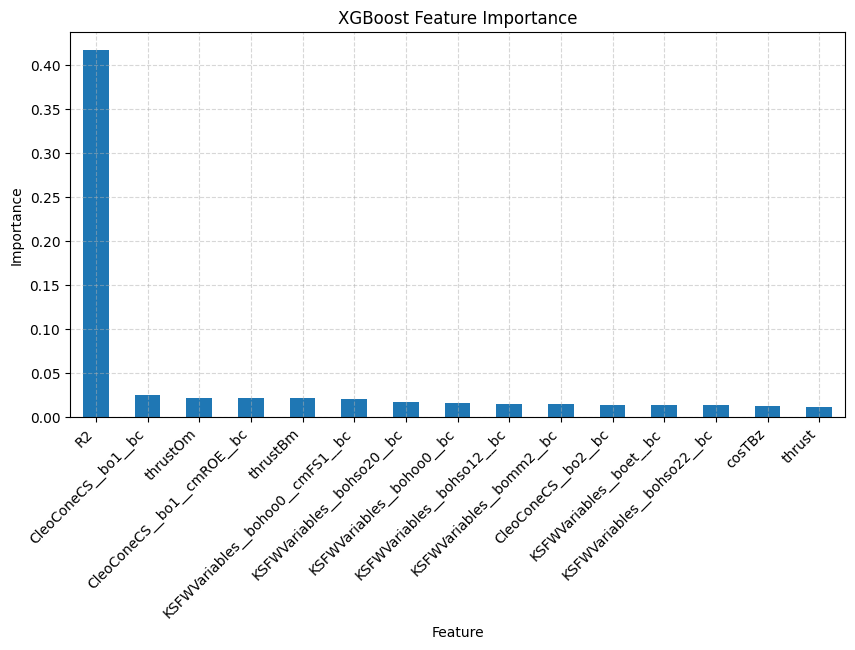

<Figure size 1000x600 with 0 Axes>

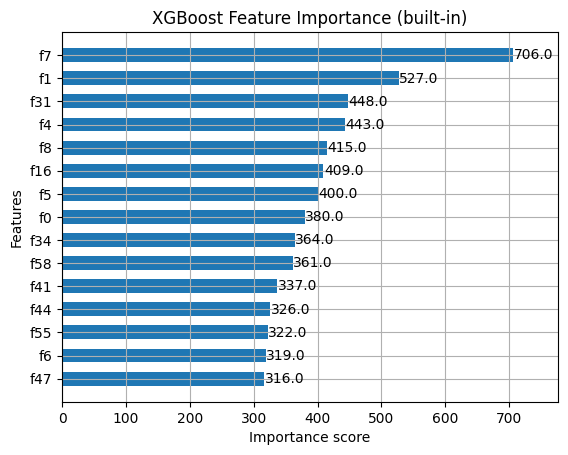

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# --------------------------
# Load data
# --------------------------
df = pd.read_csv("data_hep - data_hep.csv")

# Drop bookkeeping col
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

# Map event type -> binary class
def map_binary(t):
    if t in (0,1):
        return "BB"          # Signal
    else:
        return "continuum"   # Background

df["binary_label"] = df["type"].map(map_binary)
print("Event counts:\n", df["binary_label"].value_counts())

# --------------------------
# Prepare features
# --------------------------
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
features = [c for c in numeric_cols if c != "type"]

# Drop constants
const_cols = [c for c in features if df[c].nunique() <= 1]
df = df.drop(columns=const_cols)
features = [f for f in features if f not in const_cols]

# Drop low variance
variances = df[features].var()
low_var = variances[variances < 1e-8].index.tolist()
df = df.drop(columns=low_var)
features = [f for f in features if f not in low_var]

# --------------------------
# Train/test split
# --------------------------
X = df[features].fillna(0).values
y = df["binary_label"].values

le = LabelEncoder()
y_enc = le.fit_transform(y)  # 0 = BB, 1 = continuum

Xtr, Xte, ytr, yte = train_test_split(
    X, y_enc, test_size=0.25, stratify=y_enc, random_state=42
)

# --------------------------
# Scale features
# --------------------------
scaler = StandardScaler().fit(Xtr)
Xtr_s = scaler.transform(Xtr)
Xte_s = scaler.transform(Xte)

# --------------------------
# 1. Random Forest
# --------------------------
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,        # Let trees grow fully
    min_samples_leaf=5,    # Prevent overfitting
    random_state=42,
    n_jobs=-1
)
rf.fit(Xtr_s, ytr)
ypred_rf = rf.predict(Xte_s)

print("\n=== Random Forest ===")
print(classification_report(yte, ypred_rf, target_names=le.classes_, zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(yte, ypred_rf))

# --------------------------
# 2. Gradient Boosting (XGBoost)
# --------------------------
xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb_model.fit(Xtr_s, ytr)
ypred_xgb = xgb_model.predict(Xte_s)

print("\n=== XGBoost ===")
print(classification_report(yte, ypred_xgb, target_names=le.classes_, zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(yte, ypred_xgb))

# --------------------------
# Optional: Feature importance from Random Forest
# --------------------------
importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
top_features = importances.head(15)
print("\nTop 15 features from RF:\n", top_features)
top_features.plot(kind='bar', figsize=(10,4), title='Random Forest Feature Importance')
plt.show()
import matplotlib.pyplot as plt
import pandas as pd

# --------------------------
# XGBoost feature importance
# --------------------------
xgb_importances = pd.Series(xgb_model.feature_importances_, index=features).sort_values(ascending=False)

# Top 15 features
top_xgb = xgb_importances.head(15)
print("Top 15 XGBoost features:\n", top_xgb)

# Plot
plt.figure(figsize=(10,5))
top_xgb.plot(kind='bar', title='XGBoost Feature Importance')
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Optional: XGBoost built-in plot
from xgboost import plot_importance

plt.figure(figsize=(10,6))
plot_importance(xgb_model, max_num_features=15, height=0.6)
plt.title("XGBoost Feature Importance (built-in)")
plt.show()

Event counts:
 binary_label
BB           35765
continuum    34841
Name: count, dtype: int64

=== RandomForest ===
              precision    recall  f1-score   support

          BB       0.85      0.88      0.86      8942
   continuum       0.87      0.84      0.85      8710

    accuracy                           0.86     17652
   macro avg       0.86      0.86      0.86     17652
weighted avg       0.86      0.86      0.86     17652

Confusion Matrix:
 [[7840 1102]
 [1385 7325]]


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [20:34:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== XGBoost ===
              precision    recall  f1-score   support

          BB       0.88      0.90      0.89      8942
   continuum       0.89      0.87      0.88      8710

    accuracy                           0.88     17652
   macro avg       0.88      0.88      0.88     17652
weighted avg       0.88      0.88      0.88     17652

Confusion Matrix:
 [[8021  921]
 [1140 7570]]
[LightGBM] [Info] Number of positive: 26131, number of negative: 26823
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15045
[LightGBM] [Info] Number of data points in the train set: 52954, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493466 -> initscore=-0.026137
[LightGBM] [Info] Start training from score -0.026137
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



=== LightGBM ===
              precision    recall  f1-score   support

          BB       0.87      0.90      0.88      8942
   continuum       0.89      0.87      0.88      8710

    accuracy                           0.88     17652
   macro avg       0.88      0.88      0.88     17652
weighted avg       0.88      0.88      0.88     17652

Confusion Matrix:
 [[8022  920]
 [1168 7542]]

Model comparison:
               accuracy  f1_score
RandomForest  0.859109  0.858989
XGBoost       0.883243  0.883166
LightGBM      0.881713  0.881626


<Figure size 600x400 with 0 Axes>

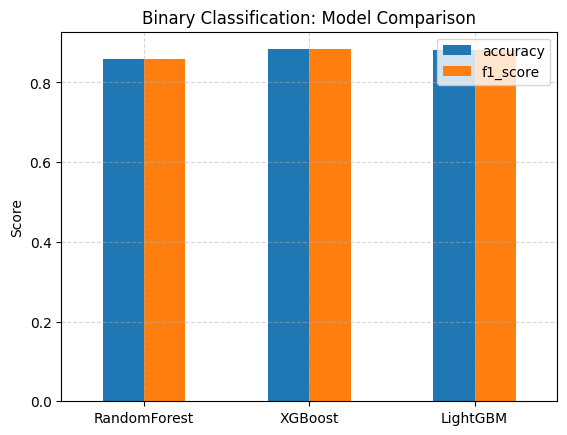

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Tree-based models
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

# --------------------------
# Load data
# --------------------------
df = pd.read_csv("data_hep - data_hep.csv")

if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

# Binary mapping
def map_binary(t):
    if t in (0,1):
        return "BB"
    else:
        return "continuum"

df["binary_label"] = df["type"].map(map_binary)
print("Event counts:\n", df["binary_label"].value_counts())

# Features
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
features = [c for c in numeric_cols if c != "type"]

# Drop constants and low variance
const_cols = [c for c in features if df[c].nunique() <= 1]
df = df.drop(columns=const_cols)
features = [f for f in features if f not in const_cols]

variances = df[features].var()
low_var = variances[variances < 1e-8].index.tolist()
df = df.drop(columns=low_var)
features = [f for f in features if f not in low_var]

# --------------------------
# Train/test split
# --------------------------
X = df[features].fillna(0).values
y = df["binary_label"].values

le = LabelEncoder()
y_enc = le.fit_transform(y)  # 0 = BB, 1 = continuum

Xtr, Xte, ytr, yte = train_test_split(
    X, y_enc, test_size=0.25, stratify=y_enc, random_state=42
)

# Scale features
scaler = StandardScaler().fit(Xtr)
Xtr_s = scaler.transform(Xtr)
Xte_s = scaler.transform(Xte)

# --------------------------
# Models dictionary
# --------------------------
models = {
    "RandomForest": RandomForestClassifier(n_estimators=300, max_depth=None, min_samples_leaf=5, random_state=42, n_jobs=-1),
    "XGBoost": xgb.XGBClassifier(n_estimators=300, max_depth=6, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8,
                                 use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": lgb.LGBMClassifier(n_estimators=300, max_depth=6, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, random_state=42)
}

# --------------------------
# Train, predict, evaluate
# --------------------------
results = {}

for name, model in models.items():
    model.fit(Xtr_s, ytr)
    ypred = model.predict(Xte_s)

    print(f"\n=== {name} ===")
    print(classification_report(yte, ypred, target_names=le.classes_, zero_division=0))
    print("Confusion Matrix:\n", confusion_matrix(yte, ypred))

    results[name] = {
        "accuracy": (ypred == yte).mean(),
        "f1_score": classification_report(yte, ypred, output_dict=True)["macro avg"]["f1-score"]
    }

# --------------------------
# Compare accuracies and F1
# --------------------------
results_df = pd.DataFrame(results).T
print("\nModel comparison:\n", results_df)

# Plot comparison
plt.figure(figsize=(6,4))
results_df[["accuracy","f1_score"]].plot(kind='bar', rot=0)
plt.title("Binary Classification: Model Comparison")
plt.ylabel("Score")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

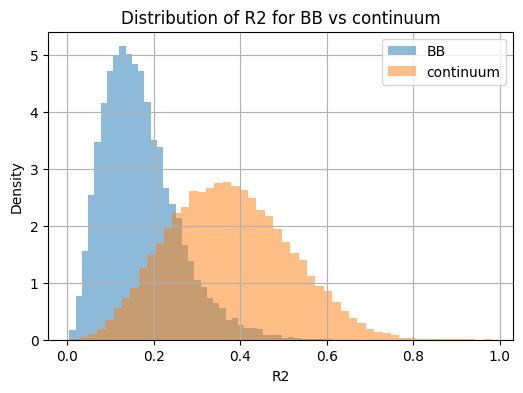

In [ ]:
# -------------------------
# Plot one feature for BB vs continuum
# -------------------------
import matplotlib.pyplot as plt

feature = "R2"   # replace with any numeric feature you want

plt.figure(figsize=(6,4))

# Plot histogram for BB
bb_data = df[df["binary_label"]=="BB"][feature].dropna()
plt.hist(bb_data, bins=50, density=True, alpha=0.5, label="BB", color="C0")

# Plot histogram for continuum
cont_data = df[df["binary_label"]=="continuum"][feature].dropna()
plt.hist(cont_data, bins=50, density=True, alpha=0.5, label="continuum", color="C1")

plt.xlabel(feature)
plt.ylabel("Density")
plt.title(f"Distribution of {feature} for BB vs continuum")
plt.legend()
plt.grid(True)
plt.show()

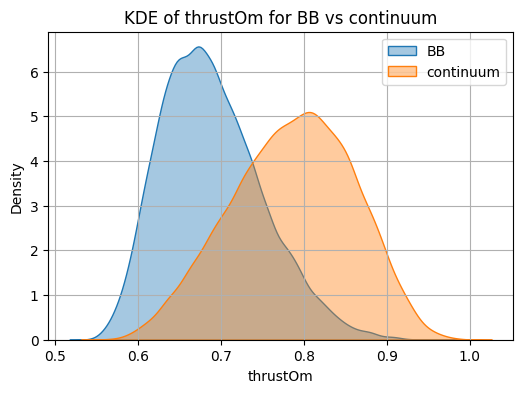

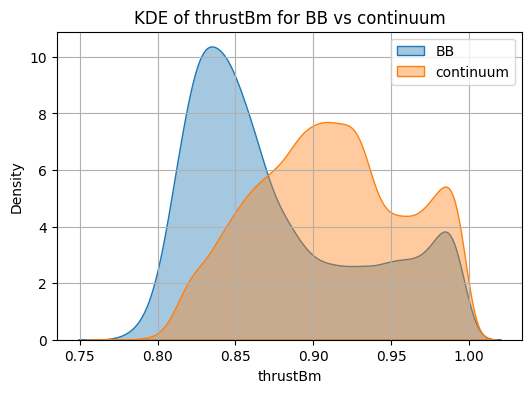

In [ ]:
# -------------------------
# KDE plot for thrustOm and thrustBm
# -------------------------
import matplotlib.pyplot as plt
import seaborn as sns

features_to_plot = ["thrustOm", "thrustBm"]

for feature in features_to_plot:
    plt.figure(figsize=(6,4))

    # KDE for BB
    bb_data = df[df["binary_label"]=="BB"][feature].dropna()
    sns.kdeplot(bb_data, label="BB", color="C0", fill=True, alpha=0.4)

    # KDE for continuum
    cont_data = df[df["binary_label"]=="continuum"][feature].dropna()
    sns.kdeplot(cont_data, label="continuum", color="C1", fill=True, alpha=0.4)

    plt.xlabel(feature)
    plt.ylabel("Density")
    plt.title(f"KDE of {feature} for BB vs continuum")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# -------------------------
# Compute BB-continuum overlap (threshold 98%)
# -------------------------
import numpy as np
from scipy.stats import gaussian_kde

low_overlap_features = []

for feature in features_to_plot:
    if feature not in df.columns:
        continue

    bb_data = df[df["binary_label"]=="BB"][feature].dropna()
    cont_data = df[df["binary_label"]=="continuum"][feature].dropna()

    # Skip if not enough data
    if len(bb_data) < 2 or len(cont_data) < 2:
        continue

    # KDE objects
    bb_kde = gaussian_kde(bb_data)
    cont_kde = gaussian_kde(cont_data)

    # Common x-grid
    x_min = min(bb_data.min(), cont_data.min())
    x_max = max(bb_data.max(), cont_data.max())
    x_grid = np.linspace(x_min, x_max, 1000)

    # Evaluate KDE on the same grid
    bb_vals = bb_kde(x_grid)
    cont_vals = cont_kde(x_grid)

    # Compute overlap
    overlap_area = np.trapz(np.minimum(bb_vals, cont_vals), x_grid)  # can also use np.trapezoid
    if overlap_area < 0.98:  # changed threshold to 98%
        low_overlap_features.append((feature, overlap_area))

# Sort by overlap (lowest first)
low_overlap_features = sorted(low_overlap_features, key=lambda x: x[1])

print("Features with BB-continuum overlap < 98%:")
for f, overlap in low_overlap_features:
    print(f"{f}: {overlap:.3f}")

/tmp/ipython-input-2452603513.py:34: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  overlap_area = np.trapz(np.minimum(bb_vals, cont_vals), x_grid)  # can also use np.trapezoid


Features with BB-continuum overlap < 98%:
thrustOm: 0.472
thrustBm: 0.637


In [ ]:
import pandas as pd
import numpy as np

def list_redundant_features(input_file, threshold=0.95):
    """
    Loads data and identifies features to keep and features to ignore
    based on a multicollinearity threshold.
    """
    print(f"--- Finding Redundant Features ---")
    print(f"Using correlation threshold: {threshold}\n")
    try:
        # Load the raw data
        df = pd.read_csv(input_file)

        # Drop non-feature columns
        # Note: We also drop the target 'type' and any created labels
        non_feature_cols = ['Unnamed: 0', 'type', 'binary_flag', 'binary_label']

        # Create a list of feature columns that exist in the DataFrame
        # This avoids errors if some columns were not created
        feature_cols = [col for col in df.columns if col not in non_feature_cols]
        df_features = df[feature_cols]

        # 1. Calculate the absolute correlation matrix
        corr_matrix = df_features.corr().abs()

        # 2. Get the upper triangle of the matrix (to avoid double-counting)
        upper_tri = corr_matrix.where(
            np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
        )

        # 3. Find features with correlation greater than the threshold
        features_to_drop = set()
        for i in range(len(upper_tri.columns)):
            for j in range(i + 1, len(upper_tri.columns)):
                if upper_tri.iloc[i, j] > threshold:
                    # If correlation is above threshold,
                    # add the 'j' column to the drop list.
                    # This choice is arbitrary; we could have chosen 'i'.
                    col_to_drop = upper_tri.columns[j]
                    features_to_drop.add(col_to_drop)

        # 4. Create the final lists
        all_features = set(df_features.columns)
        features_to_keep = all_features - features_to_drop

        print("--- Results ---")
        print(f"Found {len(features_to_drop)} features to IGNORE (redundant):")
        print(list(features_to_drop))

        print(f"\nFound {len(features_to_keep)} features to USE (non-redundant):")
        print(list(features_to_keep))

        return list(features_to_keep), list(features_to_drop)

    except FileNotFoundError:
        print(f"Error: The file '{input_file}' was not found.")
        return None, None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None, None

# --- Main Execution ---
if __name__ == "__main__":
    file_path = "data_hep - data_hep.csv"

    # You can change the threshold here
    # 0.95 is a good start, 0.90 is also common
    CORRELATION_THRESHOLD = 0.97

    keep, ignore = list_redundant_features(file_path, CORRELATION_THRESHOLD)

--- Finding Redundant Features ---
Using correlation threshold: 0.97

--- Results ---
Found 13 features to IGNORE (redundant):
['KSFWVariables__bohoo2__cmFS1__bc', 'KSFWVariables__bohso10__cmFS1__bc', 'KSFWVariables__bohso00__cmFS1__bc', 'KSFWVariables__bohoo4__cmFS1__bc', 'KSFWVariables__bohoo1__cmFS1__bc', 'KSFWVariables__bohoo3__cmFS1__bc', 'KSFWVariables__bohoo2__bc', 'thrust', 'KSFWVariables__bohso20__cmFS1__bc', 'KSFWVariables__bohoo0__cmFS1__bc', 'CleoConeCS__bo9__cmROE__bc', 'KSFWVariables__bohoo4__bc', 'KSFWVariables__bohso22__bc']

Found 46 features to USE (non-redundant):
['KSFWVariables__boet__bc', 'cosTBz', 'CleoConeCS__bo1__bc', 'CleoConeCS__bo8__cmROE__bc', 'thrustBm', 'KSFWVariables__bohso20__bc', 'foxWolframR2', 'CleoConeCS__bo3__cmROE__bc', 'KSFWVariables__bohso10__bc', 'CleoConeCS__bo1__cmROE__bc', 'KSFWVariables__bohso14__cmFS1__bc', 'foxWolframR3', 'KSFWVariables__bohso22__cmFS1__bc', 'KSFWVariables__bohso12__bc', 'CleoConeCS__bo9__bc', 'KSFWVariables__bohso02__bc'

--- Step 1: Data Preparation ---
Raw data loaded successfully.
Dropped 'Unnamed: 0' column.
Created 'binary_flag' column.
Created 'binary_label' column (0 -> 'BB', 1 -> 'continuum').

--- Step 2: Exploratory Data Analysis (EDA) ---
Saved plot 'binary_class_distribution.png'.
Saved plot 'thrustBm_kde_comparison.png'

--- Step 3: Feature Selection by Correlation Threshold ---
Using correlation threshold: 0.9
Original number of features: 59
Features to IGNORE (redundant): 21
['CleoConeCS__bo6__cmROE__bc', 'KSFWVariables__bohso10__cmFS1__bc', 'KSFWVariables__bohso02__cmFS1__bc', 'KSFWVariables__bohoo0__cmFS1__bc', 'KSFWVariables__bohso24__cmFS1__bc', 'KSFWVariables__bohoo2__cmFS1__bc', 'KSFWVariables__bohso20__bc', 'KSFWVariables__bohso10__bc', 'KSFWVariables__bohoo1__cmFS1__bc', 'CleoConeCS__bo7__cmROE__bc', 'KSFWVariables__bohoo3__cmFS1__bc', 'CleoConeCS__bo8__cmROE__bc', 'KSFWVariables__bohoo4__bc', 'CleoConeCS__bo9__cmROE__bc', 'KSFWVariables__bohso00__cmFS1__bc', 'KSFWVariables__bohso

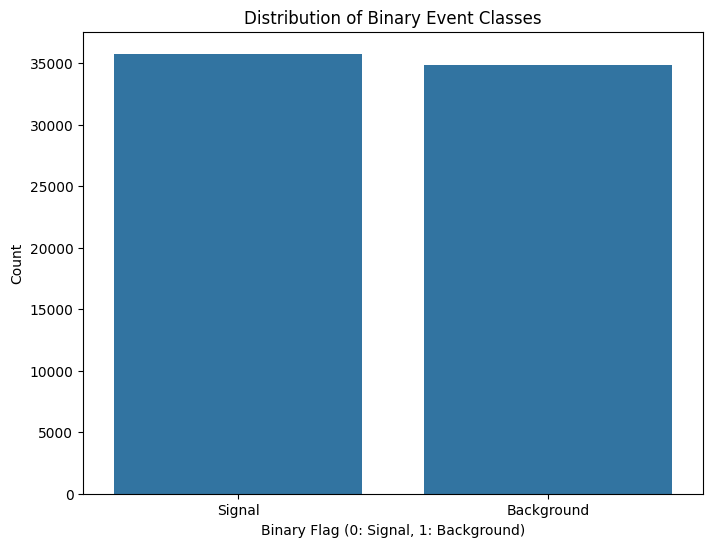

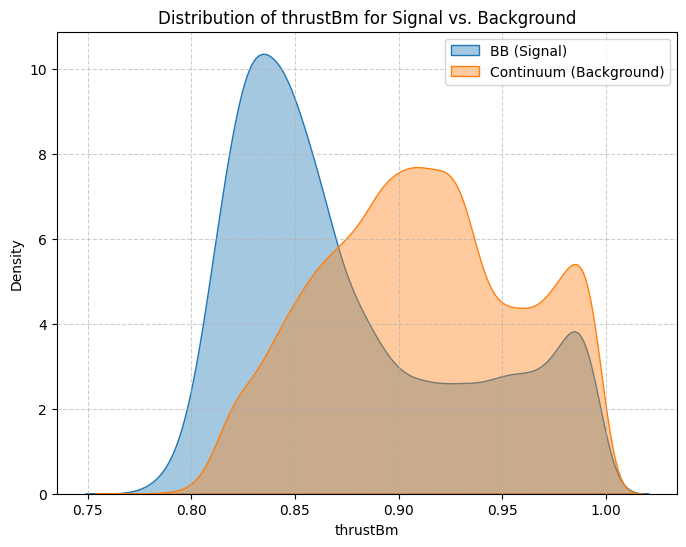

In [2]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# We are no longer using SelectKBest, as we are replacing it
# from sklearn.feature_selection import SelectKBest, f_classif

# --- Step 1: Data Preparation ---
# (This is the same as before)
def load_and_preprocess_data(input_file):
    """
    Loads data and preprocesses it.
    """
    print("--- Step 1: Data Preparation ---")
    try:
        df = pd.read_csv(input_file)
        print("Raw data loaded successfully.")
        if 'Unnamed: 0' in df.columns:
            df = df.drop(columns=['Unnamed: 0'])
            print("Dropped 'Unnamed: 0' column.")

        # Create the binary target variable
        df['binary_flag'] = df['type'].apply(lambda x: 0 if x in [0, 1] else 1)
        print("Created 'binary_flag' column.")

        # Also create the label for the EDA plots
        df['binary_label'] = df['binary_flag'].apply(lambda x: 'BB' if x == 0 else 'continuum')
        print("Created 'binary_label' column (0 -> 'BB', 1 -> 'continuum').")

        return df

    except FileNotFoundError:
        print(f"Error: The file '{input_file}' was not found.")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

# --- Step 2: Exploratory Data Analysis ---
# (This is the same as before)
def perform_eda(df):
    """
    Performs Exploratory Data Analysis on the DataFrame.
    """
    print("\n--- Step 2: Exploratory Data Analysis (EDA) ---")
    # (We can keep this function as-is to still see the plots)

    # Plot the distribution of the binary classes
    plt.figure(figsize=(8, 6))
    sns.countplot(x='binary_flag', data=df)
    plt.title('Distribution of Binary Event Classes')
    plt.xlabel('Binary Flag (0: Signal, 1: Background)')
    plt.ylabel('Count')
    plt.xticks(ticks=[0, 1], labels=['Signal', 'Background'])
    plt.savefig('binary_class_distribution.png')
    print("Saved plot 'binary_class_distribution.png'.")

    # KDE Plot 1
    plt.figure(figsize=(8, 6))
    sns.kdeplot(df[df["binary_label"]=="BB"]["thrustBm"].dropna(), label="BB (Signal)", color="C0", fill=True, alpha=0.4)
    sns.kdeplot(df[df["binary_label"]=="continuum"]["thrustBm"].dropna(), label="Continuum (Background)", color="C1", fill=True, alpha=0.4)
    plt.title("Distribution of thrustBm for Signal vs. Background")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.savefig("thrustBm_kde_comparison.png")
    print("Saved plot 'thrustBm_kde_comparison.png'")

# --- Step 3: NEW Feature Selection by Correlation Threshold ---

def select_features_by_correlation(df, threshold=0.95):
    """
    Selects features by removing highly correlated ones.

    Returns:
        X_selected (DataFrame): The DataFrame with redundant features removed.
        y (Series): The target variable.
    """
    print(f"\n--- Step 3: Feature Selection by Correlation Threshold ---")
    print(f"Using correlation threshold: {threshold}")

    # 1. Separate features (X) and target (y)
    # We must drop ALL non-feature columns
    non_feature_cols = ['type', 'binary_flag', 'binary_label']
    X = df.drop(columns=non_feature_cols)
    y = df['binary_flag']

    # 2. Calculate the absolute correlation matrix
    corr_matrix = X.corr().abs()

    # 3. Get the upper triangle of the matrix (to avoid double-counting)
    upper_tri = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )

    # 4. Find features to drop
    features_to_drop = set()
    for i in range(len(upper_tri.columns)):
        for j in range(i + 1, len(upper_tri.columns)):
            if upper_tri.iloc[i, j] > threshold:
                # If correlation is above threshold,
                # add the 'j' column to the drop list.
                # This choice is arbitrary; we just need to drop one.
                col_to_drop = upper_tri.columns[j]
                features_to_drop.add(col_to_drop)

    # 5. Create the final lists
    all_features = set(X.columns)
    features_to_keep = list(all_features - features_to_drop)

    print(f"Original number of features: {len(all_features)}")
    print(f"Features to IGNORE (redundant): {len(features_to_drop)}")
    print(list(features_to_drop))
    print(f"\nFeatures to USE (non-redundant): {len(features_to_keep)}")

    # 6. Return the selected data
    return X[features_to_keep], y

# --- Step 4: Model Training and Evaluation ---
# (This function now also handles the train/test split)

def train_and_evaluate_model(X, y):
    """
    Splits the data, then trains and evaluates the Decision Tree model.
    """
    print("\n--- Step 4: Model Training and Evaluation ---")

    # 1. Split the data into training and testing sets
    # We use the (X, y) that were already filtered by our correlation function
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Data split into training ({len(X_train)} samples) and testing ({len(X_test)} samples).")

    # 2. Initialize and train the Decision Tree Classifier
    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train, y_train)
    print("Decision Tree Classifier trained successfully.")

    # 3. Make predictions on the test set
    y_pred = model.predict(X_test)

    # 4. Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print("\n--- Model Evaluation ---")
    print(f"Accuracy: {accuracy:.4f}")

    print("\nConfusion Matrix:")
    print(pd.DataFrame(conf_matrix,
                       index=['Actual Signal', 'Actual Background'],
                       columns=['Predicted Signal', 'Predicted Background']).to_markdown(numalign="left", stralign="left"))

    print("\nClassification Report:")
    print(class_report)

    return model, accuracy, conf_matrix, class_report


# --- Main execution block ---
if __name__ == "__main__":
    file_path = "data_hep - data_hep.csv"

    # ================================================================
    # <<< YOU CAN CHANGE THE THRESHOLD HERE >>>
    # 0.95 means "ignore features that are > 95% correlated"
    # 0.90 would be more aggressive (ignore more features)
    CORRELATION_THRESHOLD = 0.90
    # ================================================================

    # Step 1: Load, preprocess
    processed_df = load_and_preprocess_data(file_path)

    if processed_df is not None:
        # Step 2: Perform EDA (generates plots)
        perform_eda(processed_df)

        # Step 3: Select features using the NEW correlation method
        X_selected, y = select_features_by_correlation(
            processed_df,
            threshold=CORRELATION_THRESHOLD
        )

        # Step 4: Train and evaluate the model on the selected features
        if X_selected is not None:
             model, accuracy, conf_matrix, class_report = train_and_evaluate_model(
                 X_selected, y
             )
        else:
            print("\nSkipping model training due to an error in feature selection.")
    else:
        print("\nSkipping all steps due to an error in data loading.")

--- Step 1: Data Preparation ---
Removed 'Unnamed: 0'
Saved → full_correlation_heatmap.png
Saved → correlation_threshold_vs_feature_count.png

--- Step 3: Feature Selection (Threshold=0.95) ---
Original features: 59
Removed redundant features: 15
Remaining features: 44

--- Step 4: Model Training & Evaluation ---
Accuracy: 0.7969
              precision    recall  f1-score   support

           0       0.80      0.80      0.80      7201
           1       0.79      0.80      0.79      6921

    accuracy                           0.80     14122
   macro avg       0.80      0.80      0.80     14122
weighted avg       0.80      0.80      0.80     14122

Saved → confusion_matrix_heatmap.png
Saved → feature_importance_ranking.png

Pipeline completed successfully. Enjoy the visuals!


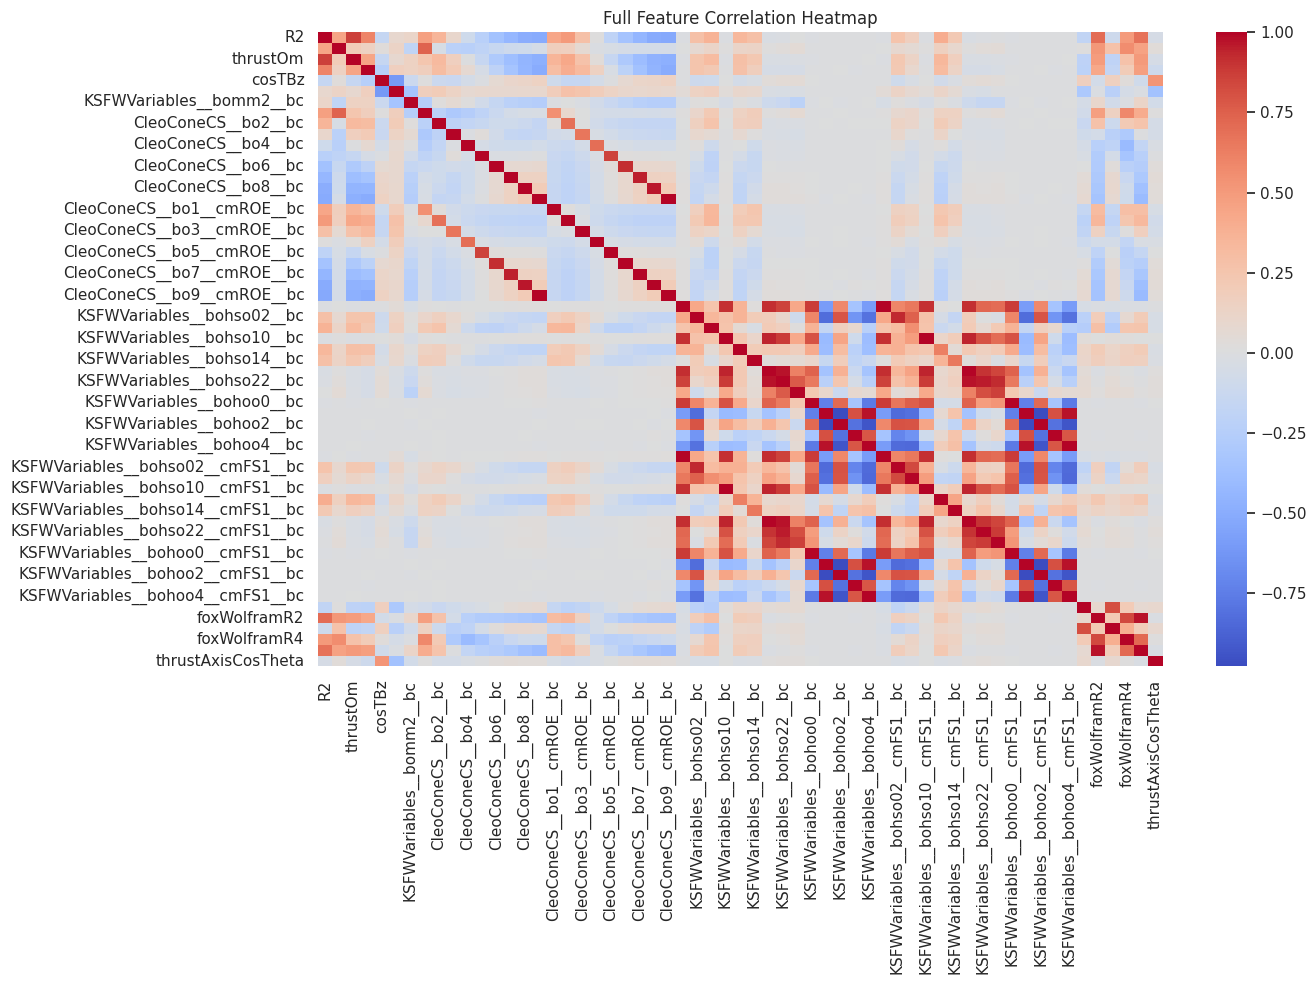

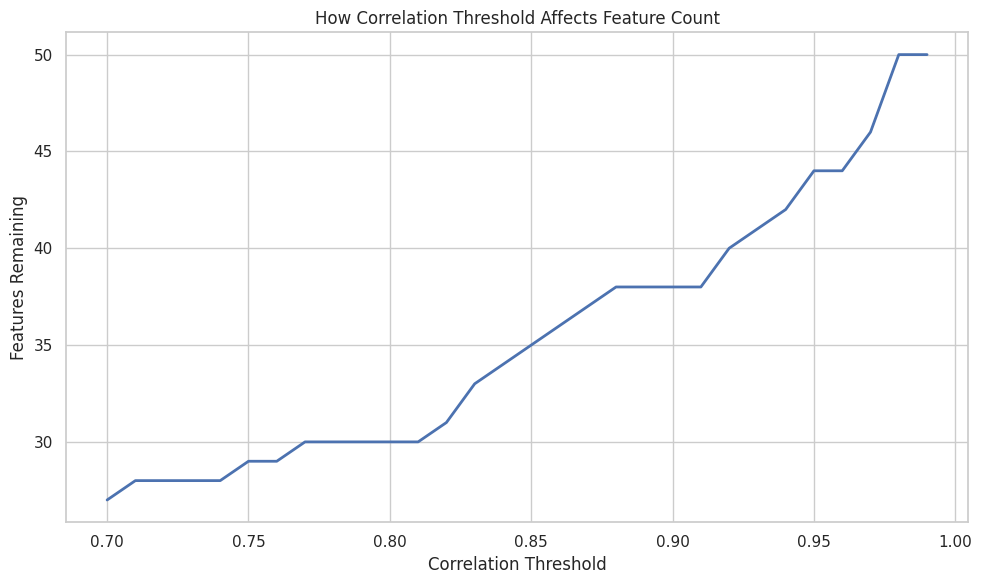

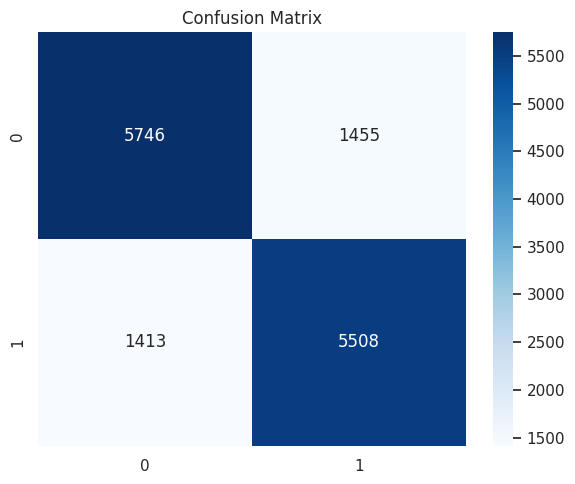

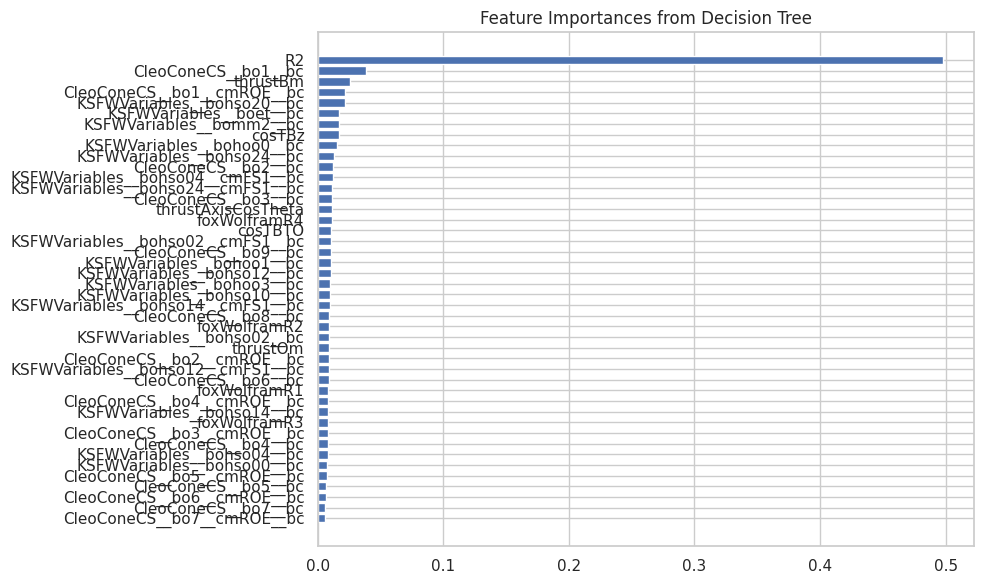

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

sns.set(style="whitegrid")

# --- Step 1: Data Preparation ---
def load_and_preprocess_data(input_file):
    print("--- Step 1: Data Preparation ---")
    df = pd.read_csv(input_file)

    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns=['Unnamed: 0'])
        print("Removed 'Unnamed: 0'")

    df['binary_flag'] = df['type'].apply(lambda x: 0 if x in [0, 1] else 1)
    df['binary_label'] = df['binary_flag'].apply(lambda x: 'BB' if x == 0 else 'continuum')

    return df

# --- NEW PLOT: Full Correlation Heatmap for Visual Context ---
def plot_full_correlation(df):
    plt.figure(figsize=(14,10))
    corr = df.drop(columns=['type','binary_flag','binary_label']).corr()
    sns.heatmap(corr, cmap="coolwarm", annot=False)
    plt.title("Full Feature Correlation Heatmap")
    plt.tight_layout()
    plt.savefig("full_correlation_heatmap.png")
    print("Saved → full_correlation_heatmap.png")

# --- Step 3: Correlation Threshold Feature Selection ---
def select_features_by_correlation(df, threshold=0.90):
    print(f"\n--- Step 3: Feature Selection (Threshold={threshold}) ---")

    X = df.drop(columns=['type','binary_flag','binary_label'])
    y = df['binary_flag']

    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    to_drop = set([
        col for col in upper.columns for idx in range(len(upper.columns))
        if upper.iloc[idx][col] > threshold
    ])

    print(f"Original features: {len(X.columns)}")
    print(f"Removed redundant features: {len(to_drop)}")
    print(f"Remaining features: {len(X.columns) - len(to_drop)}")

    X_filtered = X.drop(columns=list(to_drop))
    return X_filtered, y, corr_matrix

# --- NEW: Plot Threshold vs Features Remaining Curve ---
def plot_threshold_vs_feature_count(df, start=0.70, stop=0.99, step=0.01):
    features = []
    thresholds = np.arange(start, stop, step)

    X = df.drop(columns=['type','binary_flag','binary_label'])
    for thr in thresholds:
        corr = X.corr().abs()
        upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
        to_drop_tmp = set(col for col in upper.columns for idx in range(len(upper.columns))
                          if upper.iloc[idx][col] > thr)
        features.append(len(X.columns) - len(to_drop_tmp))

    plt.figure(figsize=(10,6))
    plt.plot(thresholds, features, linewidth=2)
    plt.xlabel("Correlation Threshold")
    plt.ylabel("Features Remaining")
    plt.title("How Correlation Threshold Affects Feature Count")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("correlation_threshold_vs_feature_count.png")
    print("Saved → correlation_threshold_vs_feature_count.png")

# --- Step 4: Model Training and Evaluation with Feature Importance Plot ---
def train_and_evaluate_model(X, y):
    print("\n--- Step 4: Model Training & Evaluation ---")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix Heatmap
    plt.figure(figsize=(6,5))
    sns.heatmap(confusion_matrix(y_test, y_pred),
                annot=True, cmap="Blues", fmt="d")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.savefig("confusion_matrix_heatmap.png")
    print("Saved → confusion_matrix_heatmap.png")

    # Plot feature importance
    importance = model.feature_importances_
    sorted_idx = np.argsort(importance)

    plt.figure(figsize=(10,6))
    plt.barh(X.columns[sorted_idx], importance[sorted_idx])
    plt.title("Feature Importances from Decision Tree")
    plt.tight_layout()
    plt.savefig("feature_importance_ranking.png")
    print("Saved → feature_importance_ranking.png")

    return model
def plot_reduced_correlation_heatmap(X_filtered):
    plt.figure(figsize=(12,9))
    reduced_corr = X_filtered.corr()

    sns.heatmap(reduced_corr, cmap="viridis", annot=False)
    plt.title("Correlation Heatmap After Feature Reduction")
    plt.tight_layout()
    plt.savefig("reduced_correlation_heatmap.png")
    print("Saved → reduced_correlation_heatmap.png")


# ------------------------------------------------------------------
if __name__ == "__main__":
    FILE = "data_hep - data_hep.csv"
    CORR_THRESHOLD = 0.95

    df = load_and_preprocess_data(FILE)

    plot_full_correlation(df)
    plot_threshold_vs_feature_count(df)

    X_filtered, y, corr_matrix = select_features_by_correlation(df, threshold=CORR_THRESHOLD)
    model = train_and_evaluate_model(X_filtered, y)

    print("\nPipeline completed successfully. Enjoy the visuals!")
# --- NEW: Heatmap AFTER Feature Reduction ---


Correlation Matrix:
                     Unnamed: 0        R2  thrustBm  thrustOm   cosTBTO  \
Unnamed: 0            1.000000  0.419839  0.145558  0.386835  0.301614   
R2                    0.419839  1.000000  0.447295  0.868096  0.599669   
thrustBm              0.145558  0.447295  1.000000  0.197056  0.152367   
thrustOm              0.386835  0.868096  0.197056  1.000000  0.446153   
cosTBTO               0.301614  0.599669  0.152367  0.446153  1.000000   
...                        ...       ...       ...       ...       ...   
foxWolframR3         -0.047294 -0.101554  0.266851 -0.190196 -0.169555   
foxWolframR4          0.164598  0.501638  0.564763  0.268713  0.199859   
thrust                0.309767  0.683179  0.461718  0.502783  0.478223   
thrustAxisCosTheta   -0.041909 -0.043061  0.037149 -0.043409 -0.101751   
type                  0.285467  0.564141  0.324981  0.469668  0.333939   

                      cosTBz  KSFWVariables__boet__bc  \
Unnamed: 0         -0.112419     

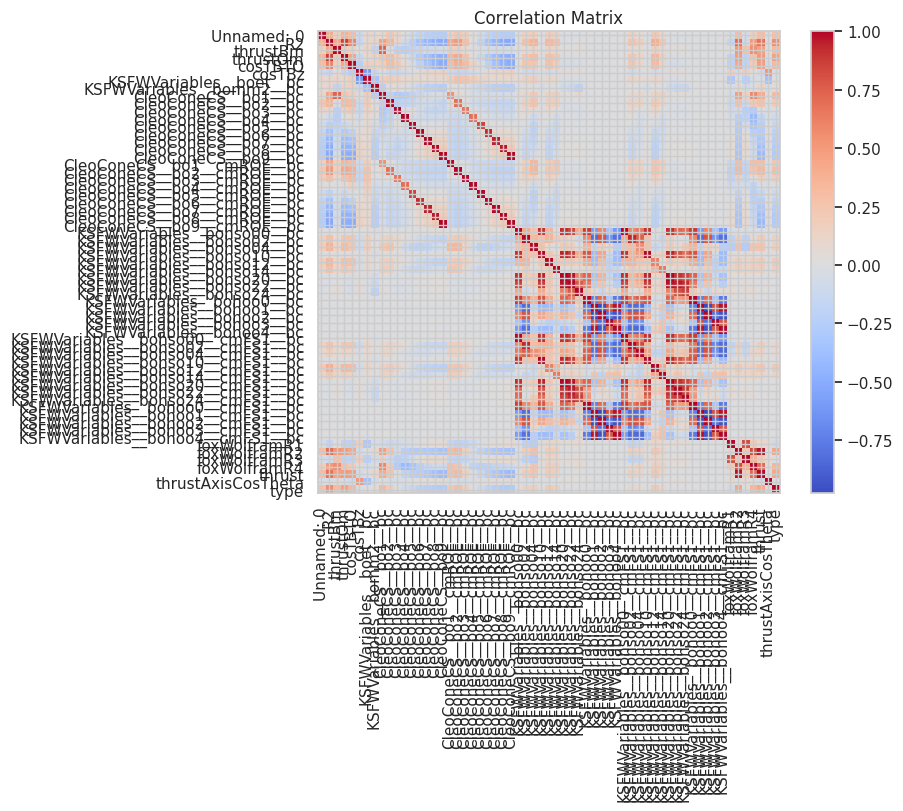


Explained variance ratio by components:
PC1: 23.10%
PC2: 13.53%
PC3: 10.78%
PC4: 5.95%
PC5: 4.27%
PC6: 3.56%
PC7: 3.25%
PC8: 3.00%
PC9: 2.94%
PC10: 2.83%
PC11: 2.79%
PC12: 2.60%
PC13: 2.52%
PC14: 2.20%
PC15: 2.01%
PC16: 1.71%
PC17: 1.44%
PC18: 1.33%
PC19: 1.12%
PC20: 1.01%
PC21: 0.93%
PC22: 0.85%
PC23: 0.83%
PC24: 0.68%
PC25: 0.63%
PC26: 0.52%
PC27: 0.48%
PC28: 0.47%
PC29: 0.40%
PC30: 0.37%
PC31: 0.27%
PC32: 0.23%
PC33: 0.22%
PC34: 0.19%
PC35: 0.15%
PC36: 0.13%
PC37: 0.12%
PC38: 0.10%
PC39: 0.10%
PC40: 0.08%
PC41: 0.07%
PC42: 0.05%
PC43: 0.04%
PC44: 0.03%
PC45: 0.03%
PC46: 0.02%
PC47: 0.02%
PC48: 0.01%
PC49: 0.01%
PC50: 0.01%
PC51: 0.01%
PC52: 0.00%
PC53: 0.00%
PC54: 0.00%
PC55: 0.00%
PC56: 0.00%
PC57: 0.00%
PC58: 0.00%
PC59: 0.00%
PC60: 0.00%
PC61: 0.00%


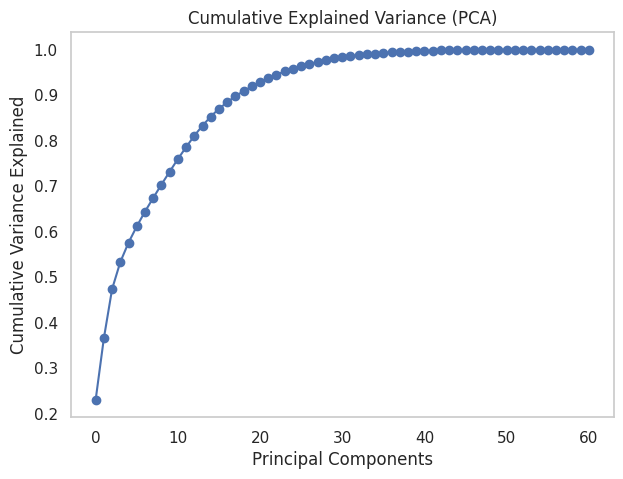


PCA Loadings:
                          PC1       PC2       PC3       PC4       PC5  \
Unnamed: 0          0.014262  0.164722  0.022588 -0.061549 -0.025004   
R2                  0.029881  0.323460  0.053067 -0.010160  0.010597   
thrustBm            0.015574  0.143501  0.056163  0.279984  0.134494   
thrustOm            0.023868  0.271895  0.033593 -0.103178 -0.020032   
cosTBTO             0.020550  0.240216  0.016742 -0.160293 -0.030157   
...                      ...       ...       ...       ...       ...   
foxWolframR3       -0.006158 -0.024784  0.048305  0.349094 -0.259670   
foxWolframR4        0.018071  0.193183  0.068064  0.352038  0.054595   
thrust              0.022681  0.268859  0.054128  0.149386 -0.056258   
thrustAxisCosTheta -0.000713 -0.034366  0.011481  0.120980 -0.171086   
type                0.017100  0.204635  0.039128  0.040754  0.003889   

                         PC6       PC7       PC8       PC9      PC10  ...  \
Unnamed: 0          0.014644 -0.022909  0.

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# ------------------------------
# 1. Load your dataset
# ------------------------------
df = pd.read_csv('data_hep - data_hep.csv')

# If necessary, select only numerical features
numerical_data = df.select_dtypes(include=[np.number])

# ------------------------------
# 2. Correlation Matrix
# ------------------------------
corr_matrix = numerical_data.corr()
print("Correlation Matrix:\n", corr_matrix)

plt.figure(figsize=(8,6))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
plt.title('Correlation Matrix')
plt.colorbar()
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.show()

# ------------------------------
# 3. PCA with correlation (via standardization)
# PCA uses covariance internally.
# To make PCA equivalent to correlation-based PCA:
# Standardize all features to mean=0, variance=1
# ------------------------------
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numerical_data)

# Perform PCA
pca = PCA()
pca_data = pca.fit_transform(scaled_data)

# ------------------------------
# 4. PCA Results
# ------------------------------
print("\nExplained variance ratio by components:")
for i, ratio in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i+1}: {ratio*100:.2f}%")

# Scree Plot
plt.figure(figsize=(7,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title('Cumulative Explained Variance (PCA)')
plt.xlabel('Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.grid()
plt.show()

# Component Loadings (feature influence on each PC)
loadings = pd.DataFrame(pca.components_.T,
                        columns=[f'PC{i+1}' for i in range(len(pca.components_))],
                        index=numerical_data.columns)
print("\nPCA Loadings:\n", loadings)
